In [1]:
from astropy.table import Table
from astropy.io import fits
import astropy.units as u
from spec_id import Scale_model,Oldest_galaxy, Median_w_Error_cont
from astropy.cosmology import Planck13, z_at_value
from scipy.interpolate import interp1d, interp2d
from scipy.ndimage import interpolation
import matplotlib.pyplot as plt
from glob import glob
import grizli.model
import seaborn as sea
import numpy as np
import pandas as pd
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
from time import time
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
galDB = pd.read_pickle('../data/sgal_param_DB.pkl')
galDB = galDB.query('ids != 14713 and ids != 38126 and ids != 48631 and ids != 41148')
lzDB = galDB.query('hi_res_specz < 1.16')
mzDB = galDB.query('1.16 < hi_res_specz < 1.3')
hzDB = galDB.query('1.3 < hi_res_specz < 1.45')
uhzDB = galDB.query('1.45 < hi_res_specz')

metal=np.round(np.arange(0.002,0.031,0.001),3)
age=np.round(np.arange(.5,6.1,.1),1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [8]:
len(metal)*len(age)*len(tau)*41

2064104

In [6]:
def Calzetti(Av,lam):
    lam = lam * 1E-4
    Rv=4.05
    k = 2.659*(-2.156 +1.509/(lam) -0.198/(lam**2) +0.011/(lam**3)) + Rv
    cal = 10**(-0.4*k*Av/Rv)    
    
    return cal

In [158]:
class Gen_spec(object):
    def __init__(self, galaxy_id, redshift,minwv = 7900, maxwv = 11300, shift = 1):
        self.galaxy_id = galaxy_id
        self.gid = int(self.galaxy_id[1:])
        self.redshift = redshift
        self.shift = shift

        """ 
        self.flt_input - grism flt (not image flt) which contains the object you're interested in modeling, this
                         will tell Grizli the PA
        **
        self.galaxy_id - used to id galaxy and import spectra
        **
        self.beam - information used to make models
        **
        self.wv - output wavelength array of simulated spectra
        **
        self.fl - output flux array of simulated spectra
        """

        gal_wv, gal_fl, gal_er = np.load(glob('../spec_stacks/*{0}*'.format(self.gid))[0])
        self.flt_input = glob('../beams/*{0}*'.format(self.gid))[0]

        IDX = [U for U in range(len(gal_wv)) if minwv <= gal_wv[U] <= maxwv]

        self.gal_wv_rf = gal_wv[IDX] / (1 + self.redshift)
        self.gal_wv = gal_wv[IDX]
        self.gal_fl = gal_fl[IDX]
        self.gal_er = gal_er[IDX]

        self.gal_wv_rf = self.gal_wv_rf[self.gal_fl > 0 ]
        self.gal_wv = self.gal_wv[self.gal_fl > 0 ]
        self.gal_er = self.gal_er[self.gal_fl > 0 ]
        self.gal_fl = self.gal_fl[self.gal_fl > 0 ]


        ## Spectrum cutouts
        self.beam = grizli.model.BeamCutout(fits_file=self.flt_input)

        ## Get sensitivity function

        flat = self.beam.flat_flam.reshape(self.beam.beam.sh_beam)
        fwv, ffl, e = self.beam.beam.optimal_extract(np.append(np.zeros([self.shift,flat.shape[0]]),flat.T[:-1],axis=0).T , bin=0)
        
        self.filt = interp1d(fwv, ffl)(self.gal_wv)
        
    def Sim_spec(self, metal, age, tau, model_redshift = 0):
        if model_redshift ==0:
            model_redshift = self.redshift
        
        model = '../../../fsps_models_for_fit/fsps_spec/m{0}_a{1}_dt{2}_spec.npy'.format(metal, age, tau)

        wave, fl = np.load(model)

        ## Compute the models
        self.beam.compute_model(spectrum_1d=[wave*(1+model_redshift),fl])

        ## Extractions the model (error array here is meaningless)
        w, f, e = self.beam.beam.optimal_extract(np.append(np.zeros([self.shift,self.beam.model.shape[0]]),
                                                           self.beam.model.T[:-1],axis=0).T , bin=0)

        ifl = interp1d(w, f)(self.gal_wv)
        adj_ifl = ifl /self.filt
        C = Scale_model(self.gal_fl, self.gal_er, adj_ifl)

        self.fl = C * adj_ifl
        
    def Sim_spec_mult(self, wave, fl, model_redshift = 0):
        if model_redshift ==0:
            model_redshift = self.redshift

        ## Compute the models
        self.beam.compute_model(spectrum_1d=[wave*(1+model_redshift), fl])

        ## Extractions the model (error array here is meaningless)
        w, f, e = self.beam.beam.optimal_extract(np.append(np.zeros([self.shift,self.beam.model.shape[0]]),
                                                           self.beam.model.T[:-1],axis=0).T , bin=0)

        self.fl = f
        self.mwv = w

In [159]:
sp = Gen_spec(galDB.gids[220],galDB.hi_res_specz[220])

../data/galaxy_flts/s39170_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39170_flt: photutils.source_properties


        Use SourceCatalog.to_table() instead. [grizli.utils]
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/skimage/measure/_moments.py:258: UserWarning: Using deprecated 2D-only, xy-coordinate interface to moments_central. This interface will be removed in scikit-image 0.16. Use moments_central(image, center=(cr, cc), order=3).
  warn(message)


Rename column: ycentroid -> y_flt
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39170_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39170_flt: save ../data/galaxy_flts/s39170_flt.detect_seg.fits, ../data/galaxy_flts/s39170_flt.detect.cat


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))


In [19]:
smtau=[0,8.0]
model_fl = []
for i in range(len(age)):
    for ii in range(len(smtau)):
        wv,fl = np.load('../../../fsps_models_for_fit/fsps_spec/m0.019_a{0}_dt{1}_spec.npy'.format(
            age[i], smtau[ii]))
        model_fl.append(fl)

In [10]:
len(model_fl)

112

In [168]:
flgrid = []
start = time()
for i in range(len(model_fl)):
    sp.Sim_spec_test(wv,model_fl[i],1.023)
    flgrid.append(sp.fl)
np.array(flgrid)
fl_mask = np.ma.masked_invalid(flgrid)
end = time()
print(end - start)

start = time()
fl_mask.data[fl_mask.mask] = 0
iflgrid = interp2d(sp.mwv,range(len(fl_mask.data)),fl_mask.data)(sp.gal_wv,range(len(fl_mask.data)))
adjflgrid = iflgrid / sp.filt
C = Scale_model_mult(sp.gal_fl,sp.gal_er,adjflgrid)
scflgrid = np.array([C]).T*adjflgrid
end = time()
print(end - start)

flgrid = []
start = time()
for i in range(len(model_fl)):
    sp.Sim_spec(wv,model_fl[i],1.023)
    flgrid.append(sp.fl)
end = time()
print(end - start)

0.049111127853393555
0.0038149356842041016
4.385589122772217


In [145]:
def Scale_model_mult(D, sig, M):
    C = np.sum(((D * M) / sig ** 2), axis=1) / np.sum((M ** 2 / sig ** 2), axis=1)
    return C

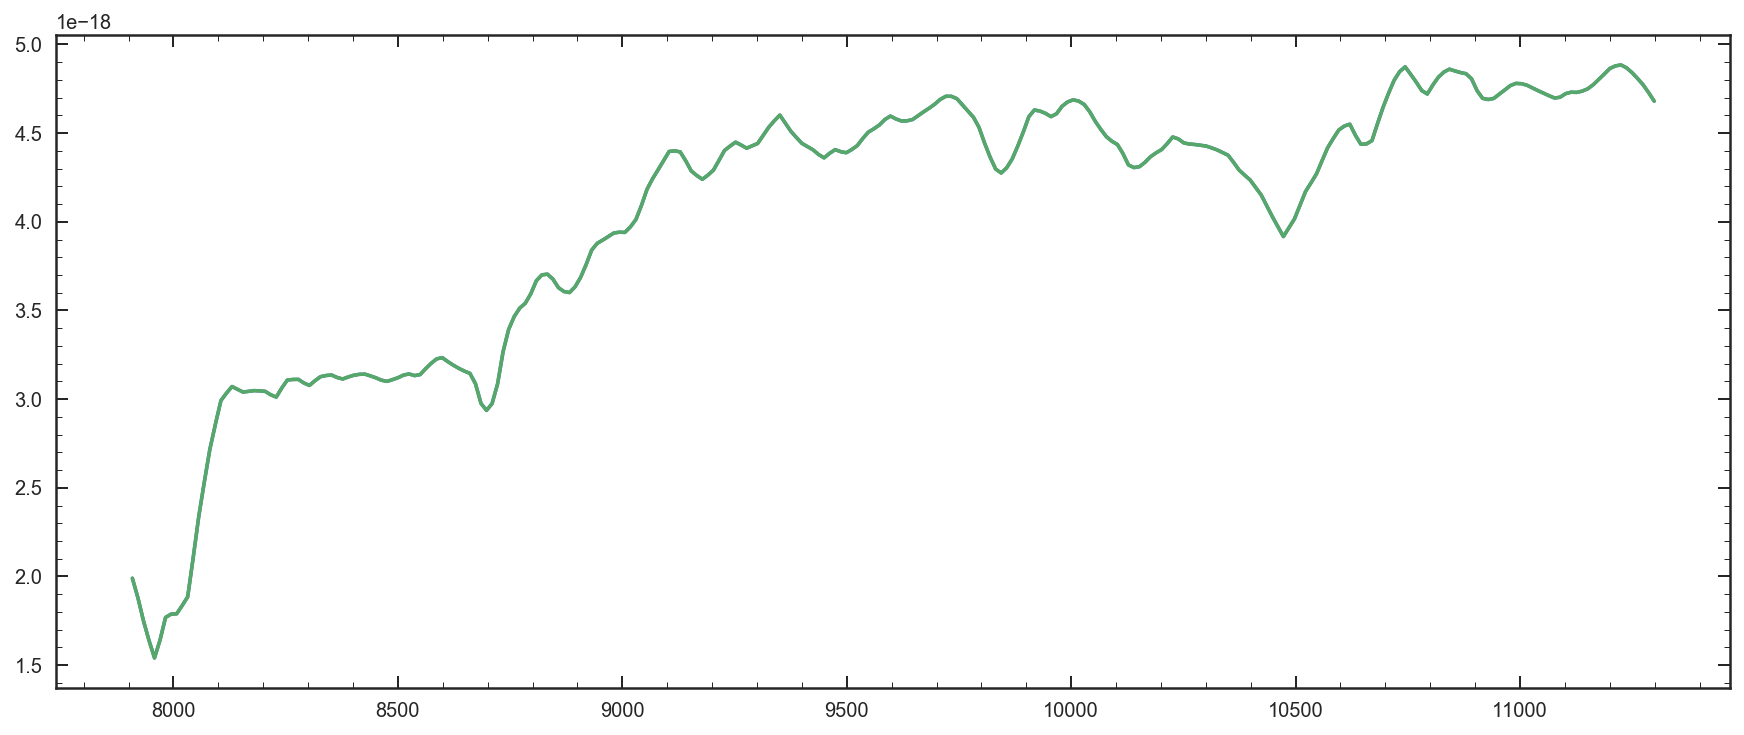

In [167]:
plt.figure(figsize=[15,6])
plt.plot(sp.gal_wv,flgrid[100])
plt.plot(sp.gal_wv,scflgrid[100])


In [37]:
num = len(metal)*len(age)*len(tau) *10 *10

In [171]:
np.array([num* 3.89/112,num* 0.049/112 + 0.0038])/60./60

array([48.57097222,  0.6118205 ])

In [177]:
def Galaxy_full_fit(metal, age, tau, rshift, specz, galaxy, name, minwv = 8000, maxwv = 11400):
    #############Read in spectra#################
    spec = Gen_spec(galaxy, specz, minwv = minwv, maxwv = maxwv)

    #### apply special mask for specific objects
    if galaxy == 'n21156' or galaxy == 'n38126':
        IDer = []
        for ii in range(len(spec.gal_wv_rf)):
            if 4855 <= spec.gal_wv_rf[ii] <= 4880:
                IDer.append(ii)
        spec.gal_er[IDer] = 1E8
        spec.gal_fl[IDer] = 0

    if galaxy == 's47677' or galaxy == 'n14713':
        IDer = []
        for ii in range(len(spec.gal_wv_rf)):
            if 4845 <= spec.gal_wv_rf[ii] <= 4863:
                IDer.append(ii)
        spec.gal_er[IDer] = 1E8
        spec.gal_fl[IDer] = 0

    if galaxy == 's39170':
        IDer = []
        for ii in range(len(spec.gal_wv_rf)):
            if 4865 <= spec.gal_wv_rf[ii] <= 4885:
                IDer.append(ii)
        spec.gal_er[IDer] = 1E8
        spec.gal_fl[IDer] = 0
 
    ##############Create chigrid and add to file#################
    model_fl = []
    for i in range(len(metal)):
        for ii in range(len(age)):
            for iii in range(len(tau)):
                wv,fl = np.load('../../../fsps_models_for_fit/fsps_spec/m{0}_a{1}_dt{2}_spec.npy'.format(
                    metal[i], age[ii], tau[iii]))
                model_fl.append(fl)
        
    mfl = []
    for i in range(len(model_fl)):
        for ii in range(len(rshift)):
            spec.Sim_spec_test(wv,model_fl[i],rshift[ii])
            mfl.append(spec.fl)
   
    np.array(mfl)
    fl_mask = np.ma.masked_invalid(mfl)
    fl_mask.data[fl_mask.mask] = 0
    iflgrid = interp2d(spec.mwv,range(len(fl_mask.data)),fl_mask.data)(spec.gal_wv,range(len(fl_mask.data)))
    adjflgrid = iflgrid / spec.filt
    
    Av = np.arange(0, 1.1, 0.1)
    for i in range(len(Av)):
        dust = Calzetti(Av[i],spec.gal_wv_rf)
        redflgrid = adjflgrid * dust
        C = Scale_model_mult(spec.gal_fl,spec.gal_er,redflgrid)
        mfl = np.array([C]).T*redflgrid
        chigrid = np.sum(((spec.gal_fl - mfl) / spec.gal_er) ** 2, axis=1).reshape([len(metal), len(age), len(tau), len(rshift)]).\
        astype(np.float128)
        np.save('../chidat/{0}_d{1}_chidata'.format(name, i +1),chigrid)

    ################Write chigrid file###############
    
#    P, PZ, Pt = Analyze_LH_lwa(chifile1 + '.npy', specz, metal, age, tau)

#    np.save('../chidat/%s_tZ_pos' % name,P)
#    np.save('../chidat/%s_Z_pos' % name,[metal,PZ])
#    np.save('../chidat/%s_t_pos' % name,[age,Pt])

    print('Done!')
    return

In [174]:
mtest=np.round(np.arange(0.002,0.031,0.008),3)
atest=np.arange(.5,6.1,.5)
tau_test=[0,8.0, 8.3, 8.48, 8.6]
z_test = np.array([1.021,1.022,1.023])

In [257]:
mtest

array([0.002, 0.01 , 0.018, 0.026])

In [302]:
len(metal)*len(age)*len(tau)*11*0.044 /60 /60

6.768471111111111

In [71]:
660/15624.

0.042242703533026116

In [175]:
start = time()
Single_gal_fit_w_redshift(mtest,age,tau,z_test,galDB.hi_res_specz[220],galDB.gids[220],'w_z_test')
end = time()
print(end - start)

../data/galaxy_flts/s39170_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39170_flt: photutils.source_properties


        Use SourceCatalog.to_table() instead. [grizli.utils]
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/skimage/measure/_moments.py:258: UserWarning: Using deprecated 2D-only, xy-coordinate interface to moments_central. This interface will be removed in scikit-image 0.16. Use moments_central(image, center=(cr, cc), order=3).
  warn(message)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf

Rename column: ycentroid -> y_flt
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39170_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39170_flt: save ../data/galaxy_flts/s39170_flt.detect_seg.fits, ../data/galaxy_flts/s39170_flt.detect.cat
709.3074498176575
Done!
727.1203598976135


In [178]:
start = time()
Single_gal_fit_w_redshift(mtest,age,tau,z_test,galDB.hi_res_specz[220],galDB.gids[220],'w_z_test')
end = time()
print(end - start)

../data/galaxy_flts/s39170_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39170_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39170_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39170_flt: save ../data/galaxy_flts/s39170_flt.detect_seg.fits, ../data/galaxy_flts/s39170_flt.detect.cat


        Use SourceCatalog.to_table() instead. [grizli.utils]
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/skimage/measure/_moments.py:258: UserWarning: Using deprecated 2D-only, xy-coordinate interface to moments_central. This interface will be removed in scikit-image 0.16. Use moments_central(image, center=(cr, cc), order=3).
  warn(message)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf

7.768373012542725
Done!
17.772820949554443


In [197]:
7.77/ (len(mtest)*len(age)*len(tau)*len(z_test)) * num /60/60

0.5215972222222222

In [200]:
6.5 / (num/10) * num /100

0.65

In [311]:
def Analyze_LH_lwa_w_redshift(chifits, metal, age, tau, rshift, age_conv='../data/light_weight_scaling_3.npy'):
    ####### Get maximum age
    max_age = Oldest_galaxy(max(rshift))

    ####### Read in file
    chi = np.load(chifits)

    chi[:, len(age[age <= max_age]):, :] = 1E5

    ####### Get scaling factor for tau reshaping
    ultau = np.append(0, np.power(10, np.array(tau)[1:] - 9))

    convtable = np.load(age_conv)

    overhead = np.zeros([len(tau),metal.size]).astype(int)
    for i in range(len(tau)):
        for ii in range(metal.size):
            amt=[]
            for iii in range(age.size):
                if age[iii] > convtable.T[i].T[ii][-1]:
                    amt.append(1)
            overhead[i][ii] = sum(amt)

    ######## Reshape likelihood to get average age instead of age when marginalized
    P_org = np.exp(-chi.astype(np.float128) / 2)
    
    Pz = np.trapz(np.trapz(np.trapz(P_org.T, metal, axis=3), age, axis=2), ultau, axis=1) /\
        np.trapz(np.trapz(np.trapz(np.trapz(P_org.T, metal, axis=3), age, axis=2), ultau, axis=1),rshift)
    
    P = np.trapz(P_org, rshift, axis=3)
    new_P = np.zeros(P.T.shape)
    for i in range(len(tau)):
        frame = np.zeros([metal.size,age.size])
        for ii in range(metal.size):
            dist = interp1d(convtable.T[i].T[ii],P.T[i].T[ii])(age[:-overhead[i][ii]])
            frame[ii] = np.append(dist,np.repeat(0, overhead[i][ii]))
        new_P[i] = frame.T

    ####### Create normalize probablity marginalized over tau
    P = new_P.T

    # test_prob = np.trapz(test_P, ultau, axis=2)
    C = np.trapz(np.trapz(np.trapz(P, ultau, axis=2), age, axis=1), metal)

    P /= C

    prob = np.trapz(P, ultau, axis=2)
    
    # #### Get Z, t, tau, and z posteriors
    PZ = np.trapz(np.trapz(P, ultau, axis=2), age, axis=1)
    Pt = np.trapz(np.trapz(P, ultau, axis=2).T, metal, axis=1)
    Ptau = np.trapz(np.trapz(P.T, metal, axis=2), age, axis=1)

    return prob.T, PZ, Pt, Ptau, Pz

In [303]:
dat = np.load('../chidat/fit_w_z_test_chidata.npy')    
max_age = Oldest_galaxy(max(z_test))

dat[:, len(age[age <= max_age]):, :] = 1E5

In [305]:
overhead = np.zeros([len(tau),metal.size]).astype(int)
for i in range(len(tau)):
    for ii in range(metal.size):
        amt=[]
        for iii in range(age.size):
            if age[iii] > convtable.T[i].T[ii][-1]:
                amt.append(1)
        overhead[i][ii] = sum(amt)

In [307]:
z_test = np.arange(1.017,1.027,0.001)

In [308]:
######## Reshape likelihood to get average age instead of age when marginalized
P_org = np.exp(-dat.astype(np.float128) / 2)
test_Pz = np.trapz(np.trapz(np.trapz(P_org.T, metal, axis=3), age, axis=2), ultau, axis=1) /\
    np.trapz(np.trapz(np.trapz(np.trapz(P_org.T, metal, axis=3), age, axis=2), ultau, axis=1),z_test)
P = np.trapz(P_org, z_test, axis=3)
new_P = np.zeros(P.T.shape)
for i in range(len(tau)):
    frame = np.zeros([metal.size,age.size])
    for ii in range(metal.size):
        dist = interp1d(convtable.T[i].T[ii],P.T[i].T[ii])(age[:-overhead[i][ii]])
        frame[ii] = np.append(dist,np.repeat(0, overhead[i][ii]))
    new_P[i] = frame.T

In [309]:
ultau = np.append(0, np.power(10, np.array(tau)[1:] - 9))

test_P = new_P.T

# test_prob = np.trapz(test_P, ultau, axis=2)
test_C = np.trapz(np.trapz(np.trapz(test_P, ultau, axis=2), age, axis=1), metal)

test_P /= test_C

# #### Get Z, t, tau, and z posteriors
test_PZ = np.trapz(np.trapz(test_P, ultau, axis=2), age, axis=1)
test_Pt = np.trapz(np.trapz(test_P, ultau, axis=2).T, metal,axis=1)
test_Ptau = np.trapz(np.trapz(test_P.T, metal, axis=2), age,axis=1)

test_PZ2 = np.trapz(np.trapz(np.trapz(P_org, z_test, axis=3), ultau, axis=2), age, axis=1) /\
    np.trapz(np.trapz(np.trapz(np.trapz(P_org, z_test, axis=3), ultau, axis=2), age, axis=1),metal)

test_Ptau2 = np.trapz(np.trapz(np.trapz(P_org.T, metal, axis=3), age, axis=2).T, z_test, axis=1) /\
    np.trapz(np.trapz(np.trapz(np.trapz(P_org.T, metal, axis=3), age, axis=2).T, z_test, axis=1),ultau)

In [313]:
Pr,PZ,Pt,Ptau,Pz = Analyze_LH_lwa_w_redshift('../chidat/fit_w_z_test_chidata.npy',metal,age,tau,z_test)

In [335]:
Z,PZT = np.load('../chidat/s39170_dtau_Z_pos_lwa_3.npy')
t,PtT = np.load('../chidat/s39170_dtau_t_pos_lwa_3.npy')

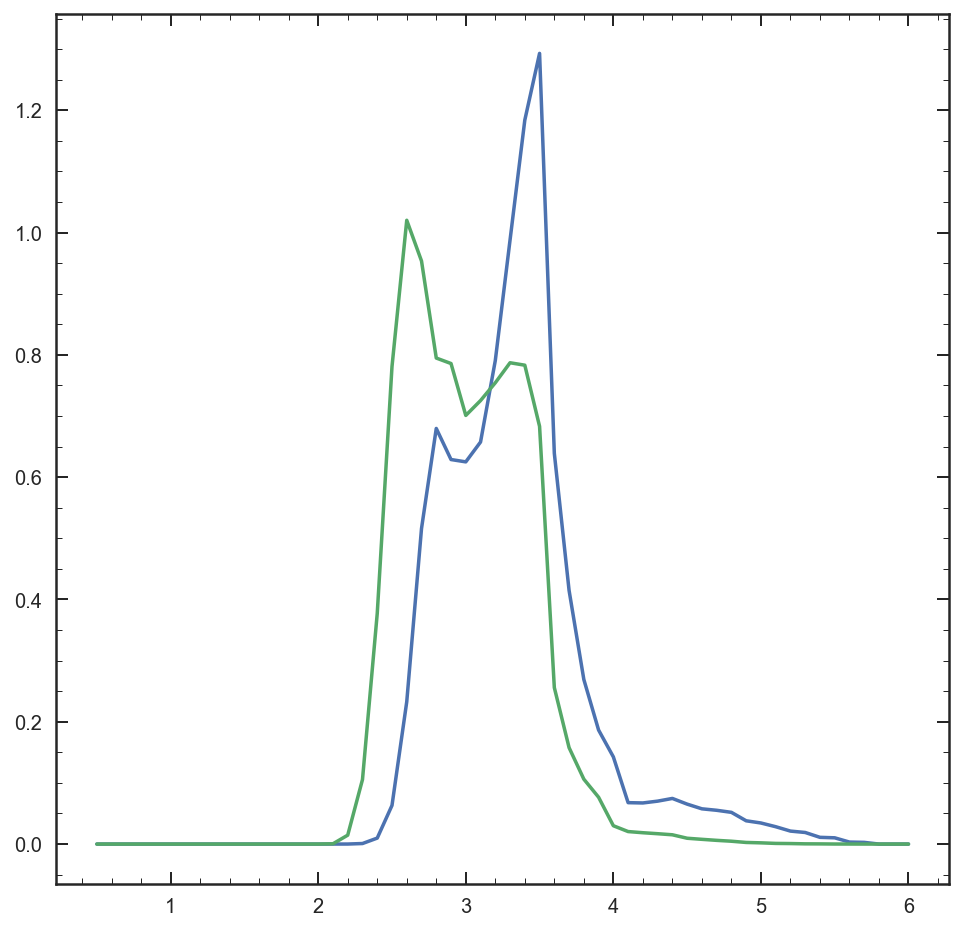

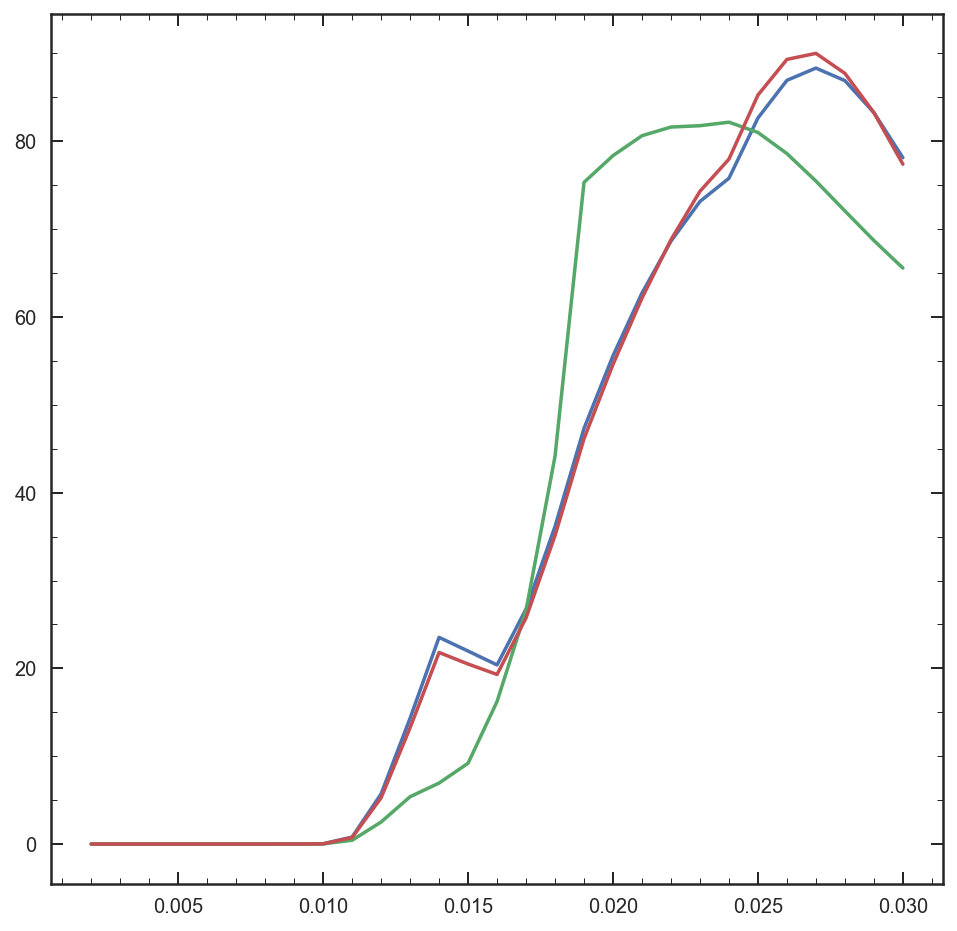

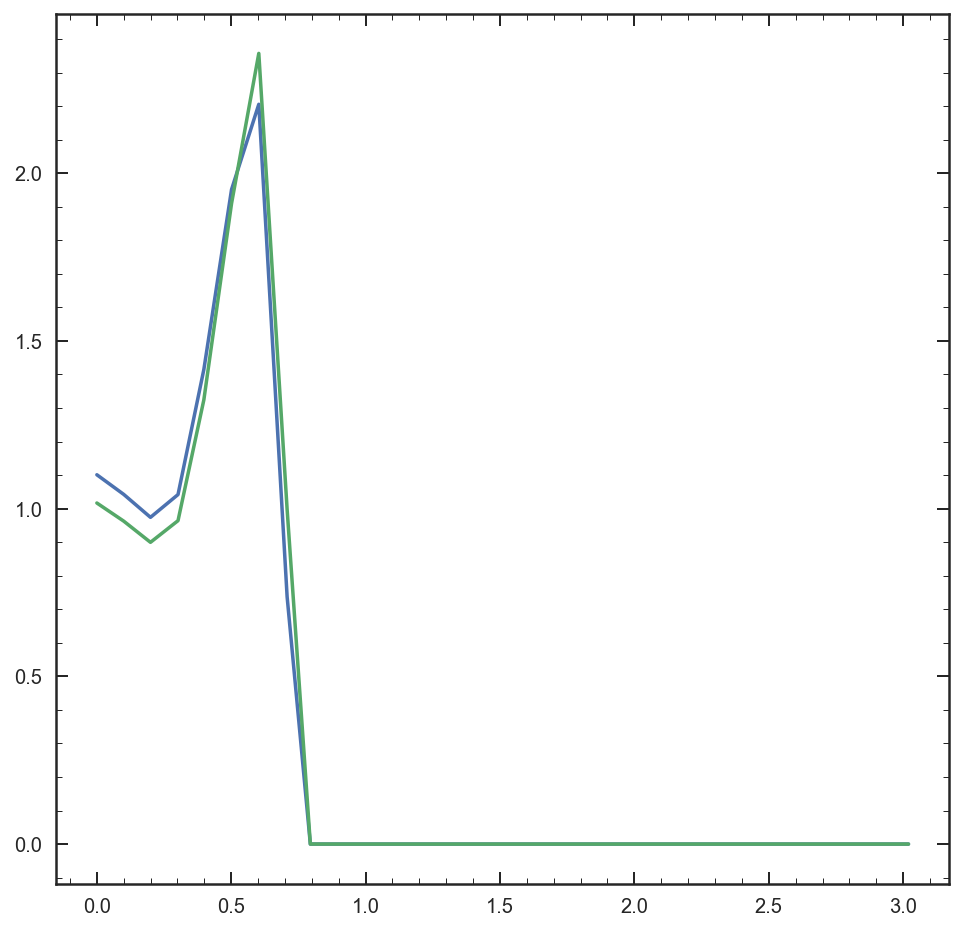

In [336]:
plt.figure(figsize=[8,8])
plt.plot(age,Pt)
plt.plot(age,PtT)
# plt.plot(age,test_Pt)
plt.figure(figsize=[8,8])
plt.plot(metal,PZ)
plt.plot(metal,PZT)
plt.plot(metal,test_PZ2)
plt.figure(figsize=[8,8])
plt.plot(ultau,Ptau)
plt.plot(ultau,test_Ptau2)

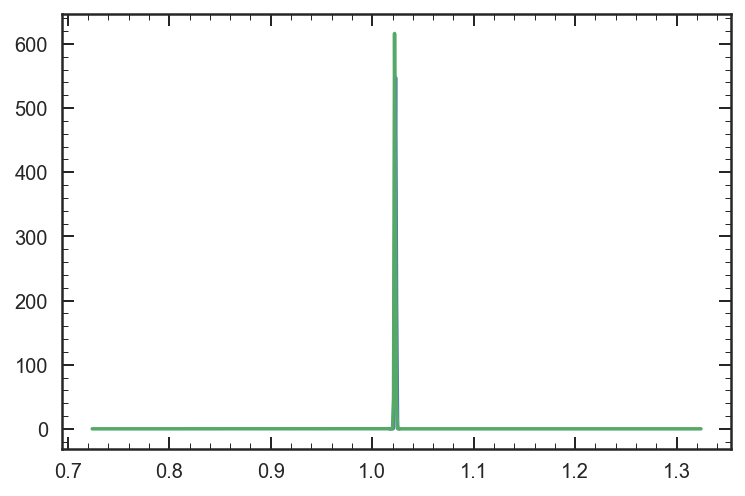

In [319]:
plt.plot(z_test,test_Pz)
plt.plot(z,Pz)

In [318]:
z,Pz = np.load('../rshift_dat/s39170_hires_Pofz.npy')

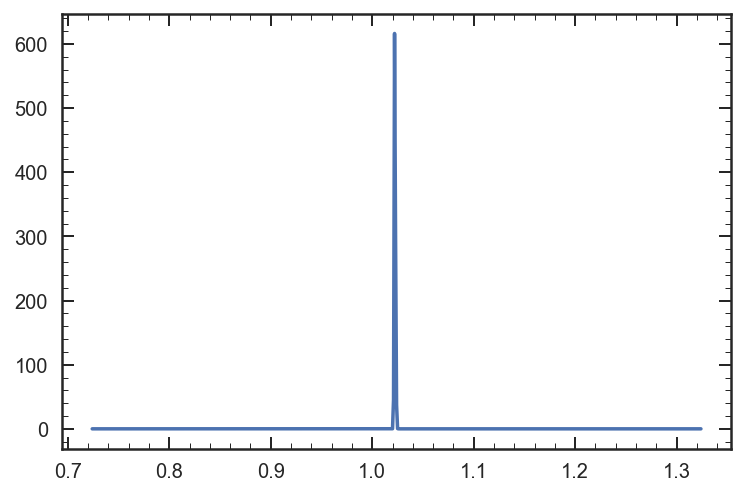

In [297]:
plt.plot(z,Pz)

In [299]:
Median_w_Error_cont(Pz,z)

(1.0233987975951912897, 0.0012024048096192395049, 0.0)

In [300]:
galDB.hi_res_specz[220]

1.022000000000001

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


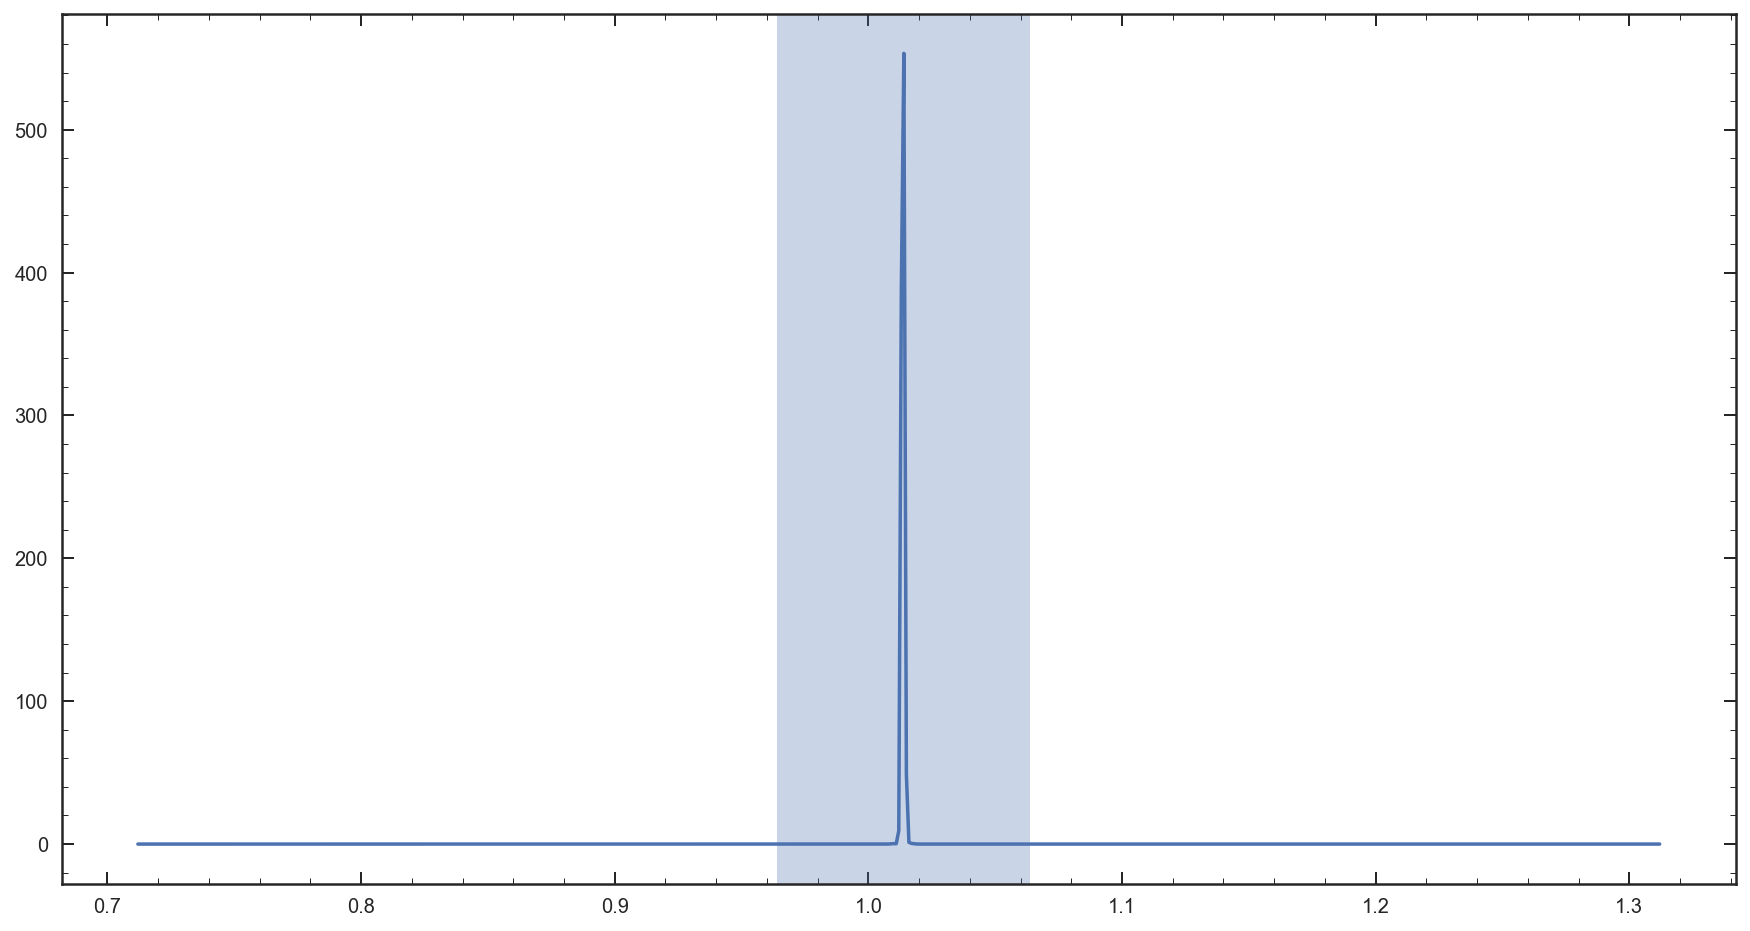

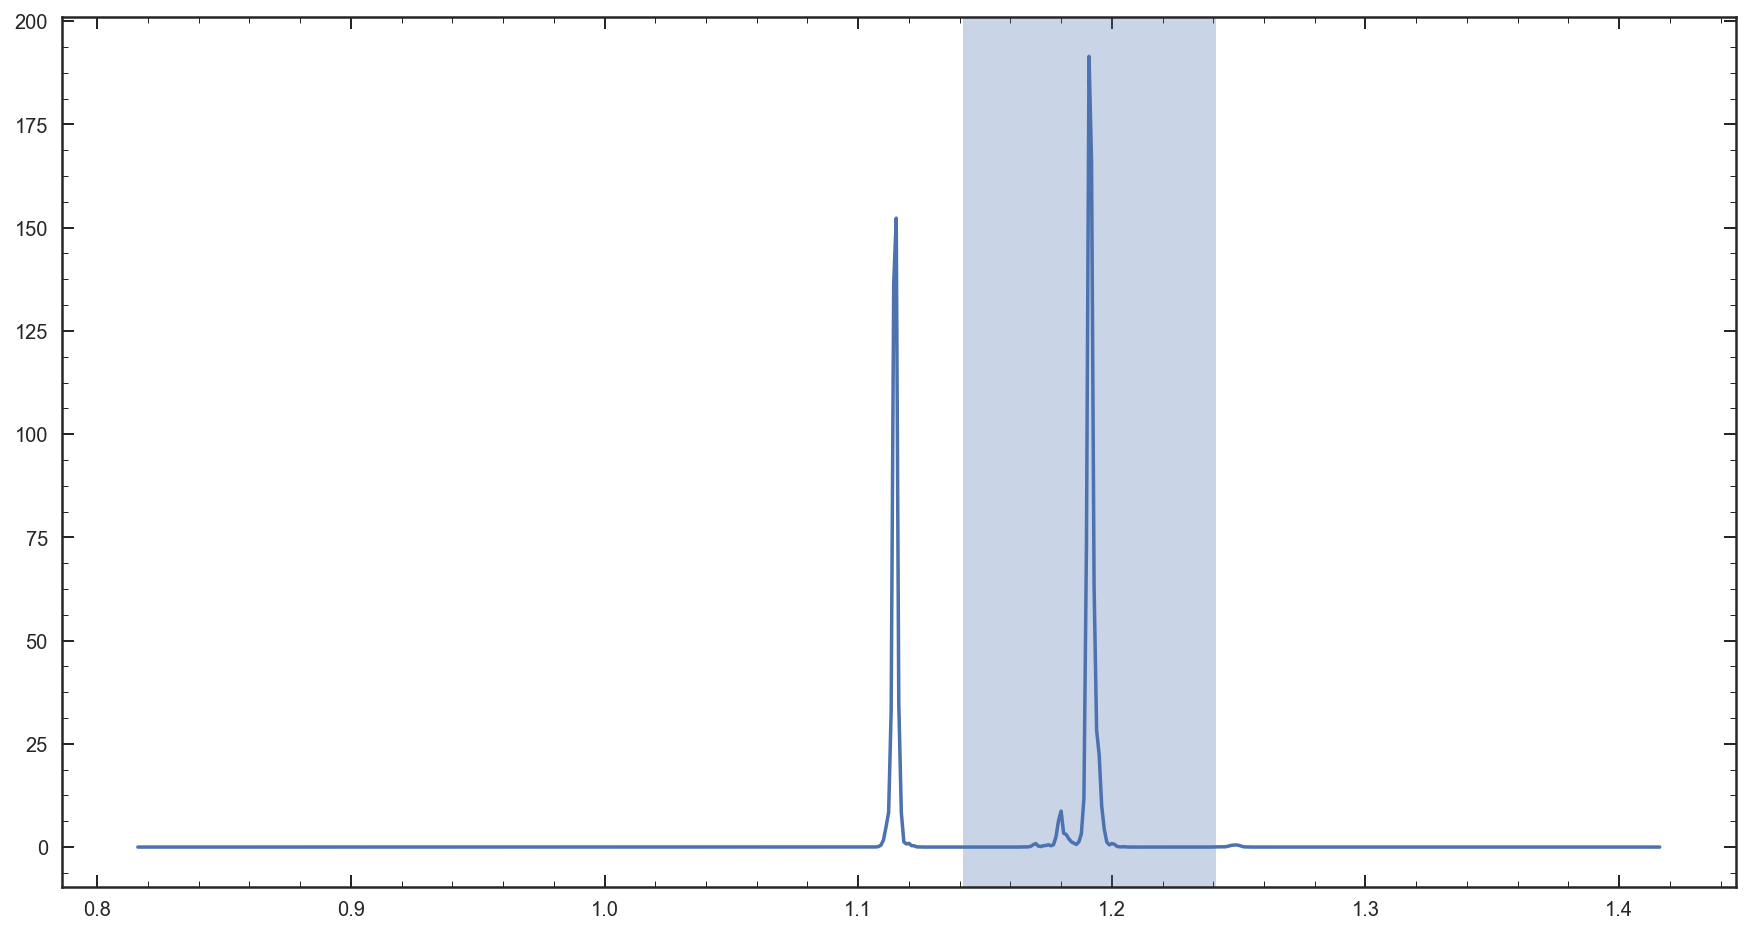

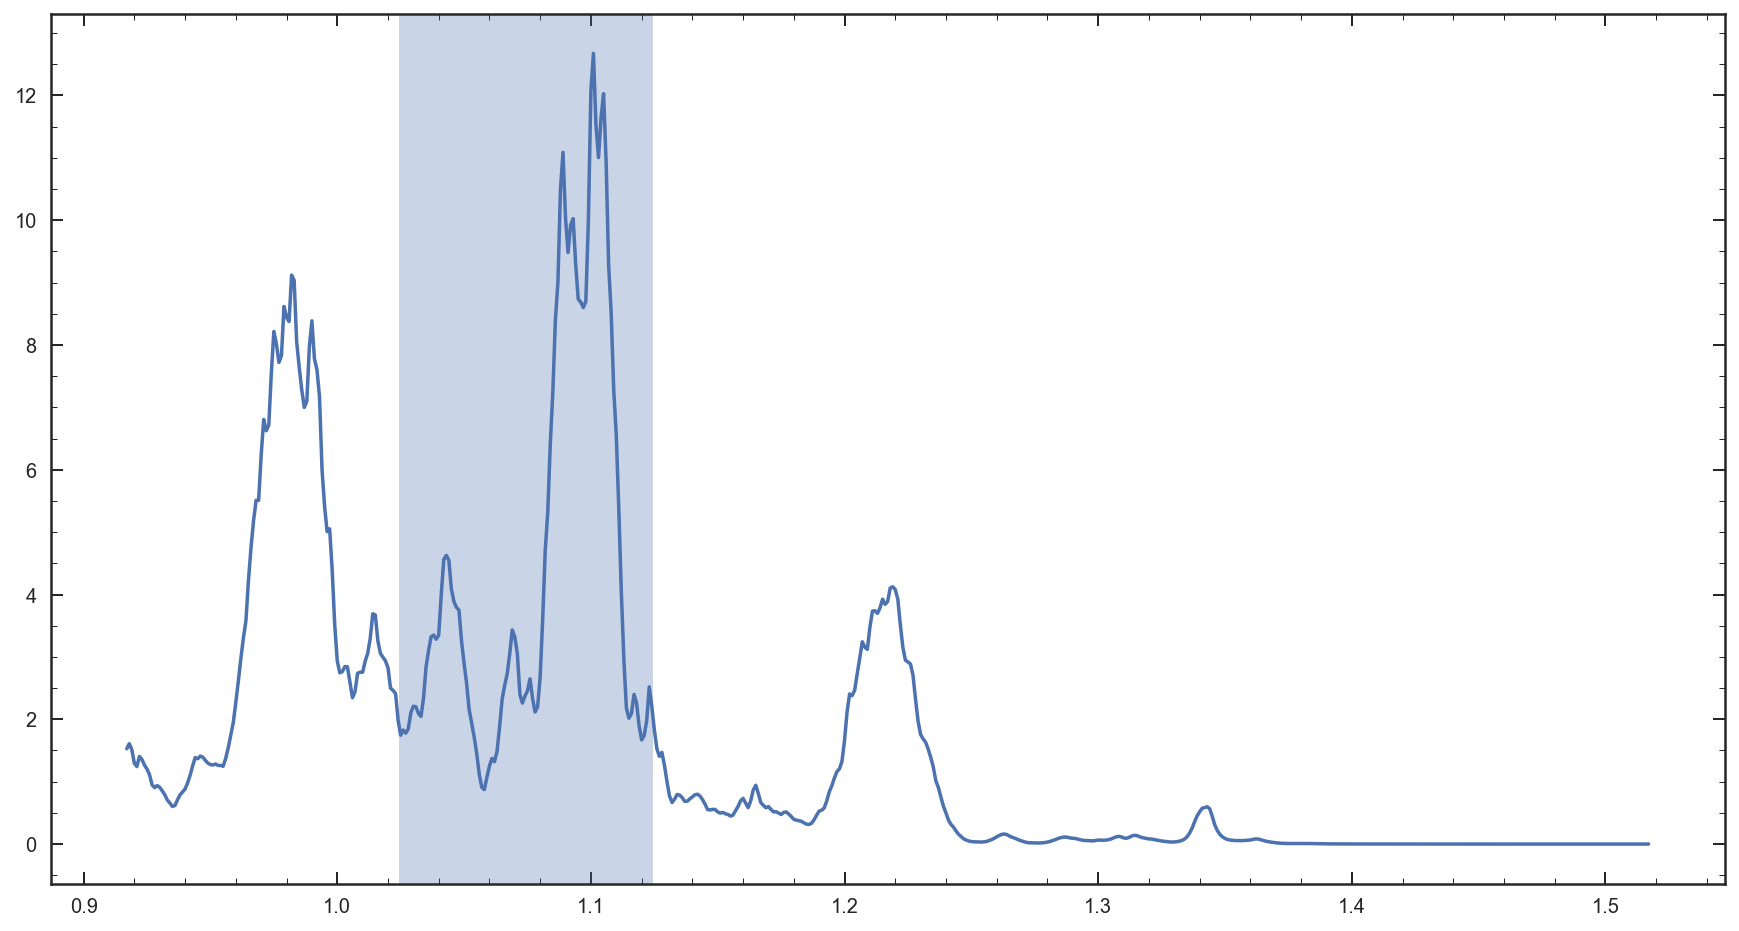

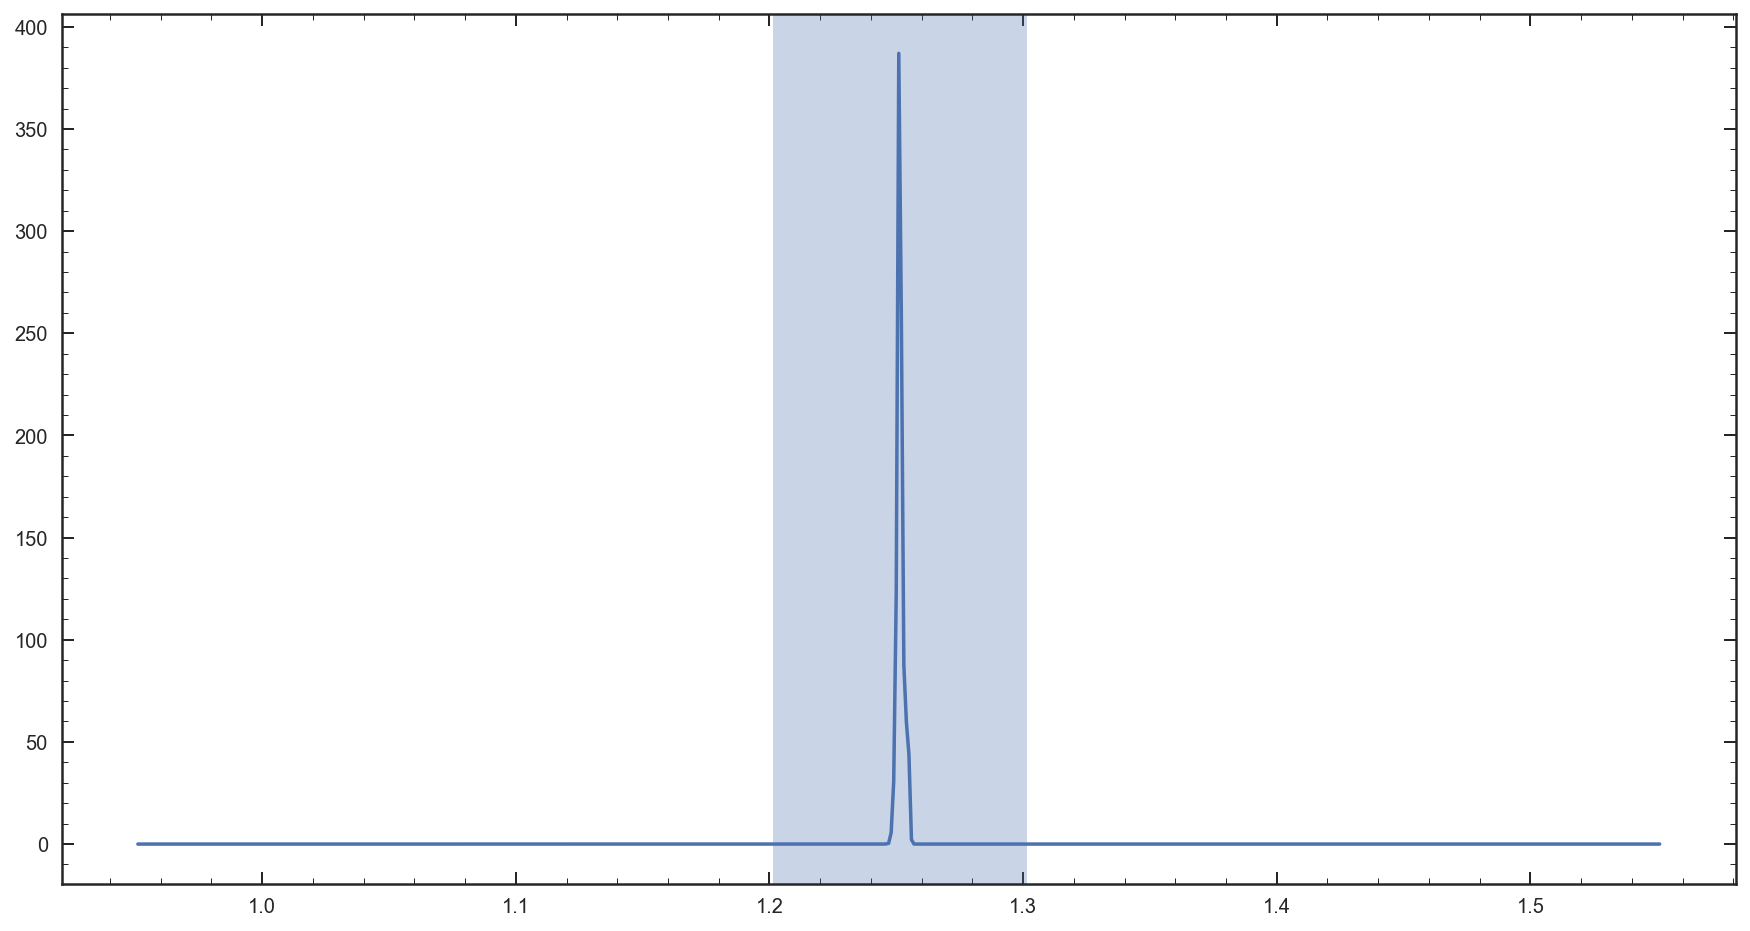

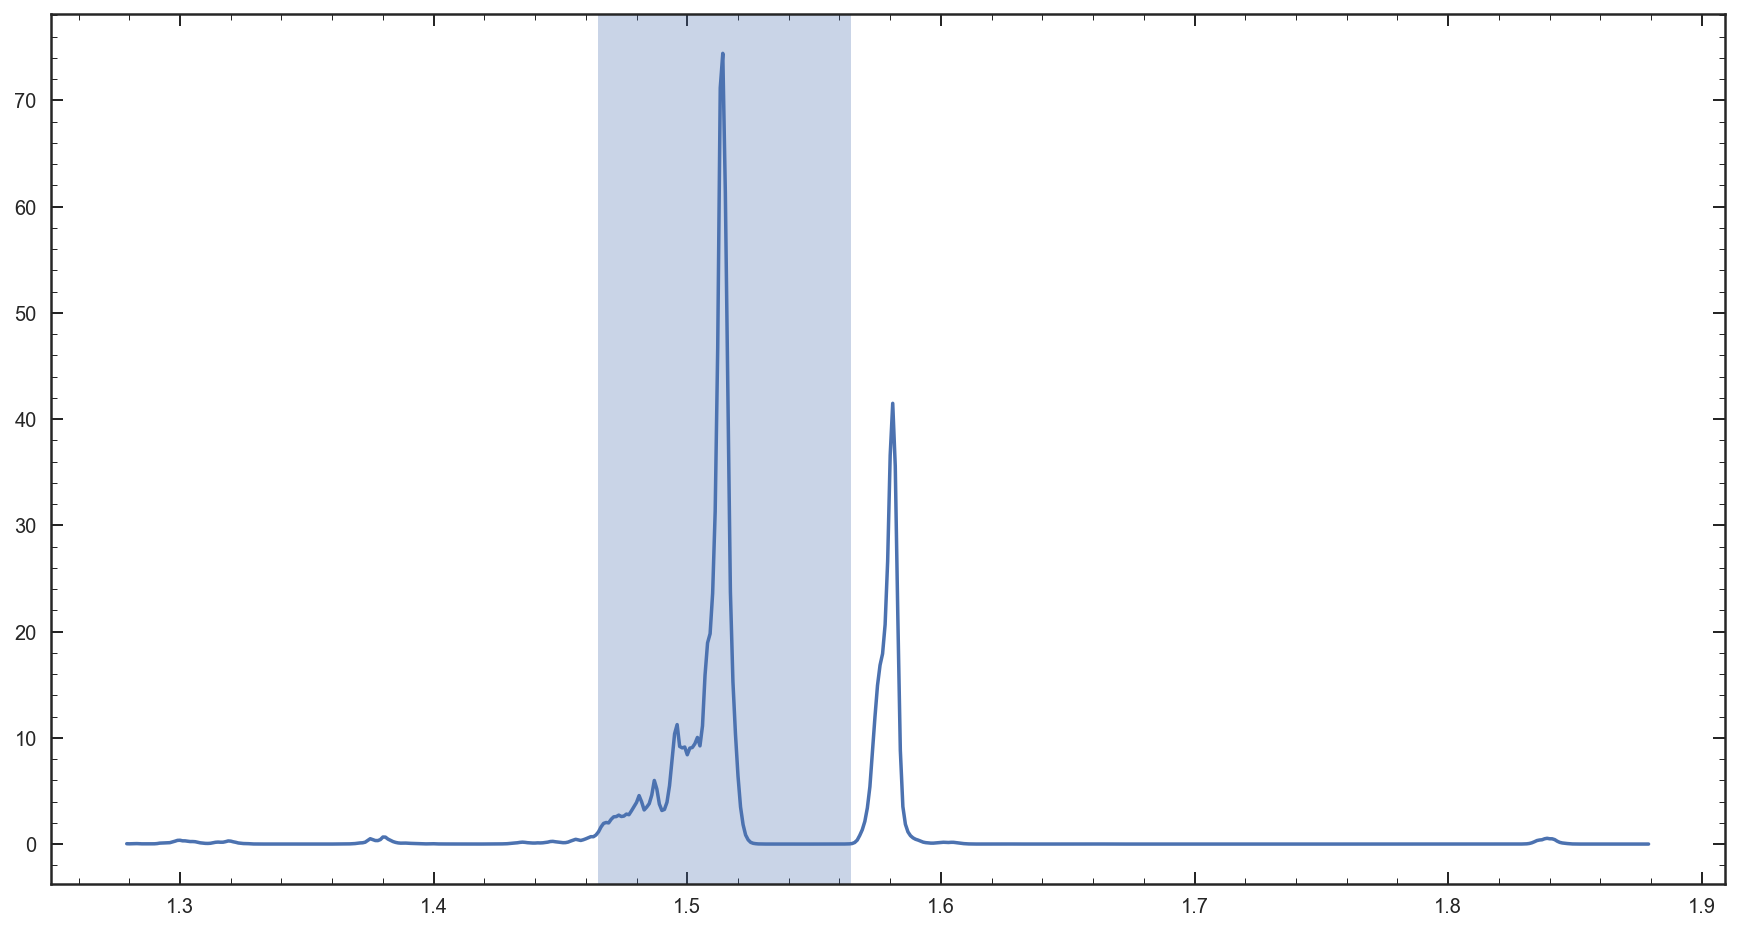

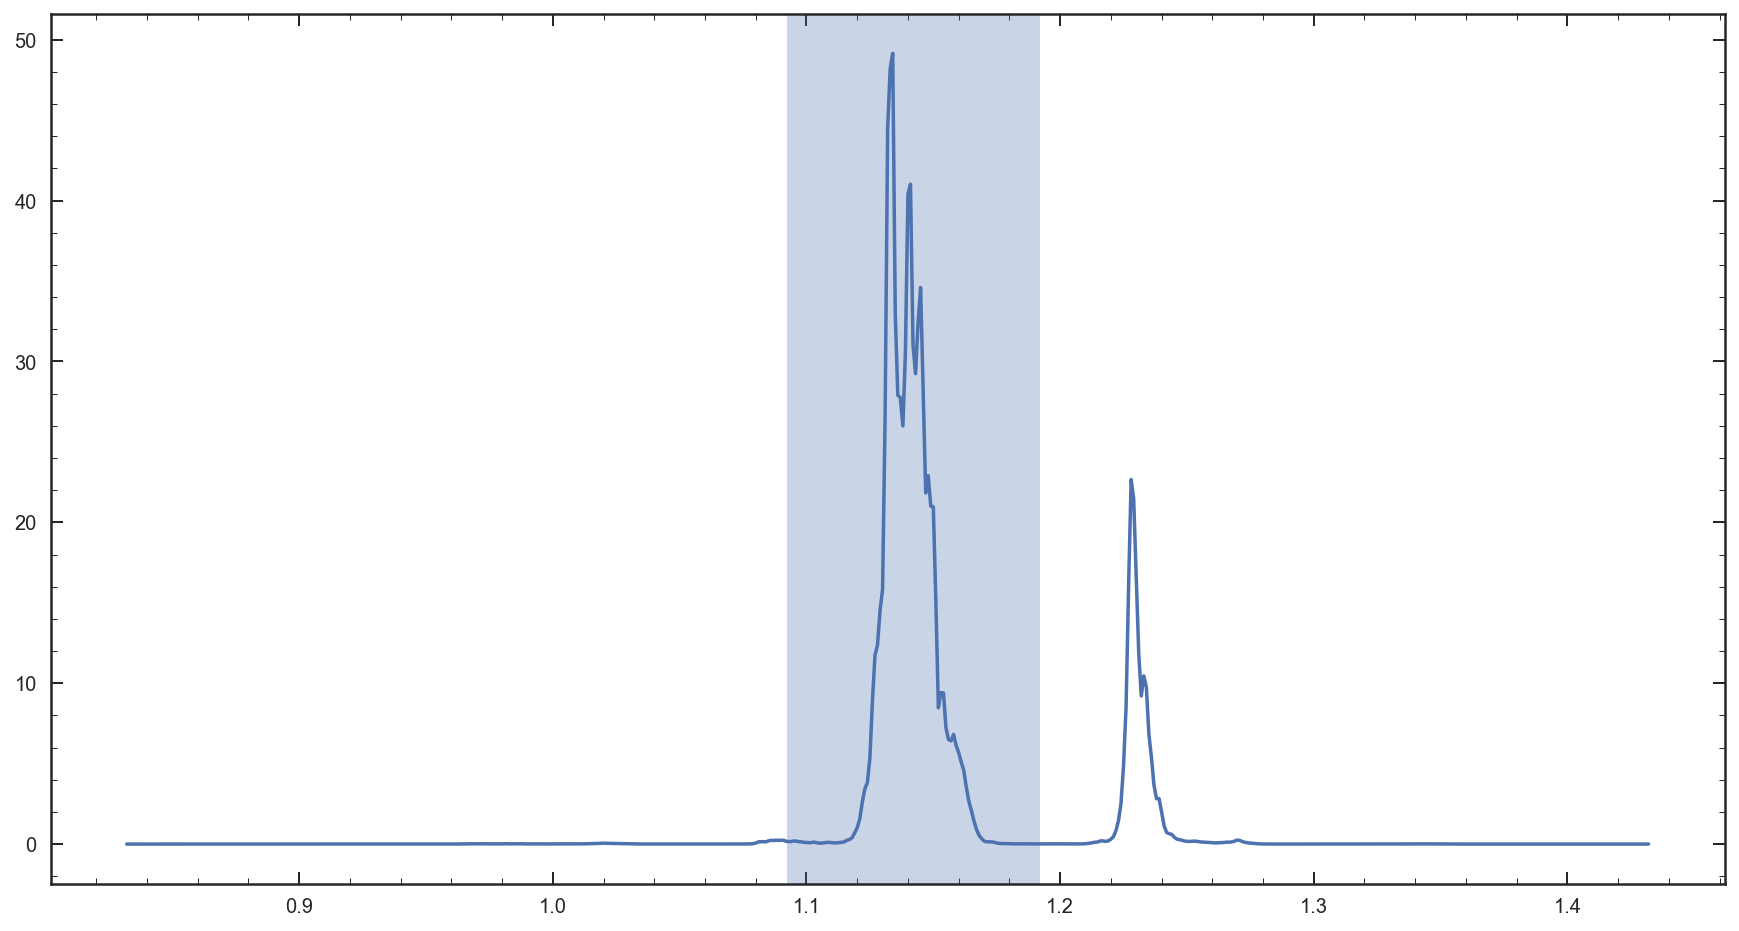

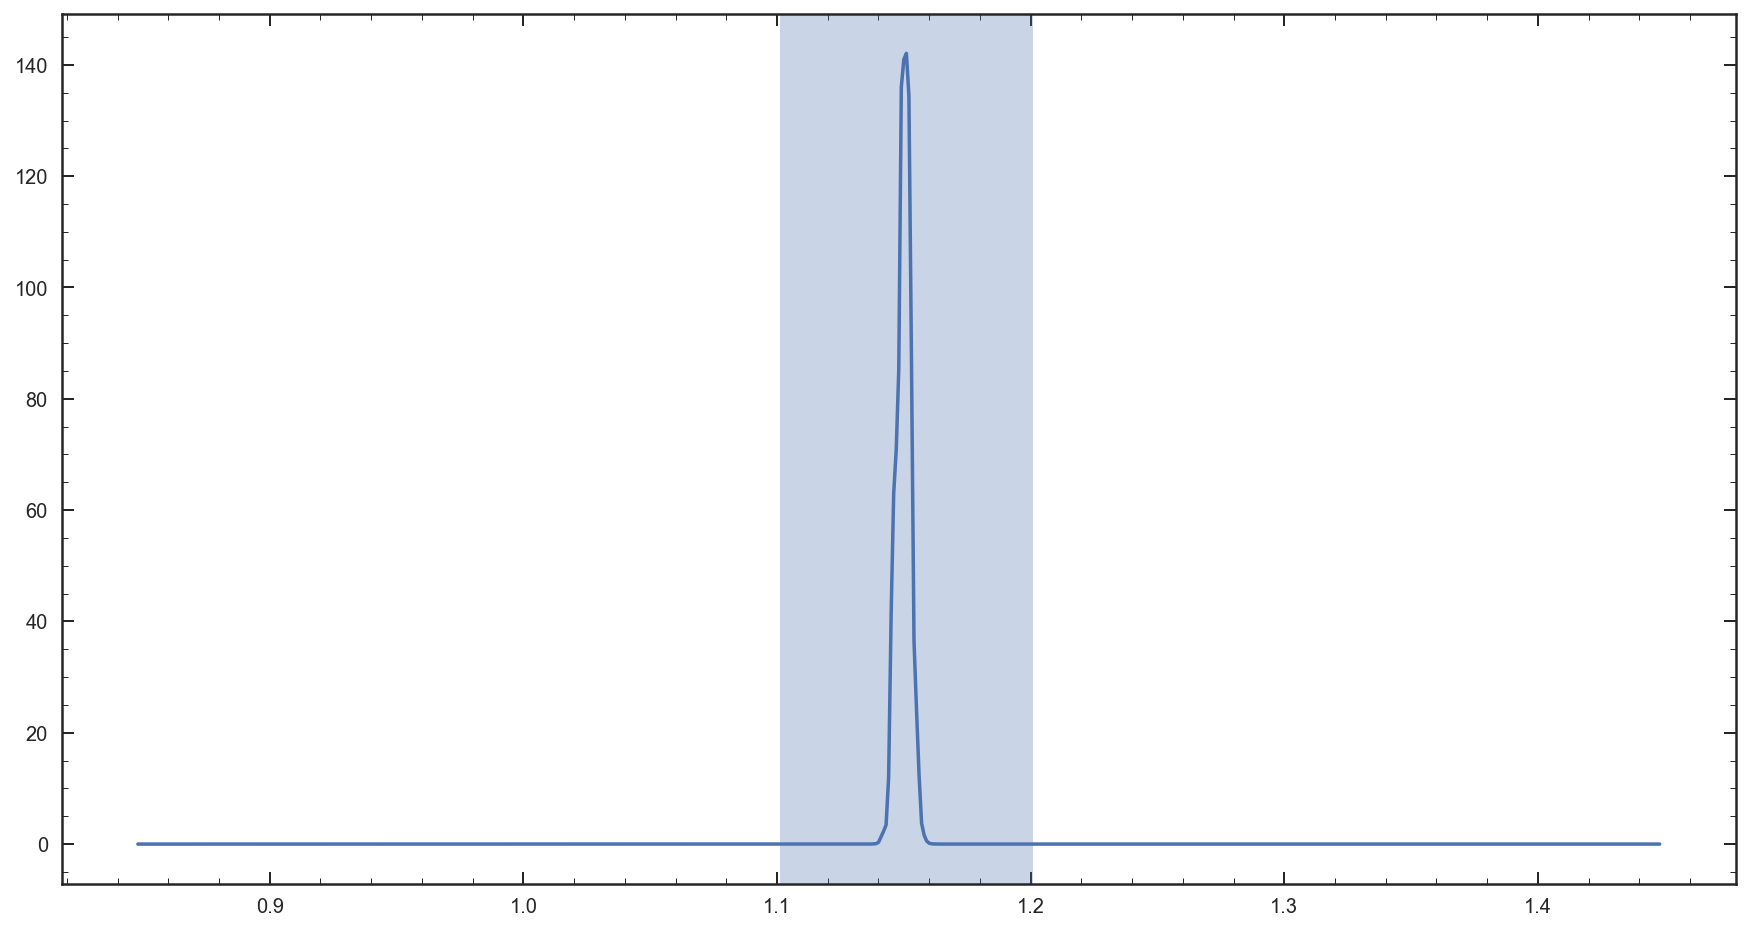

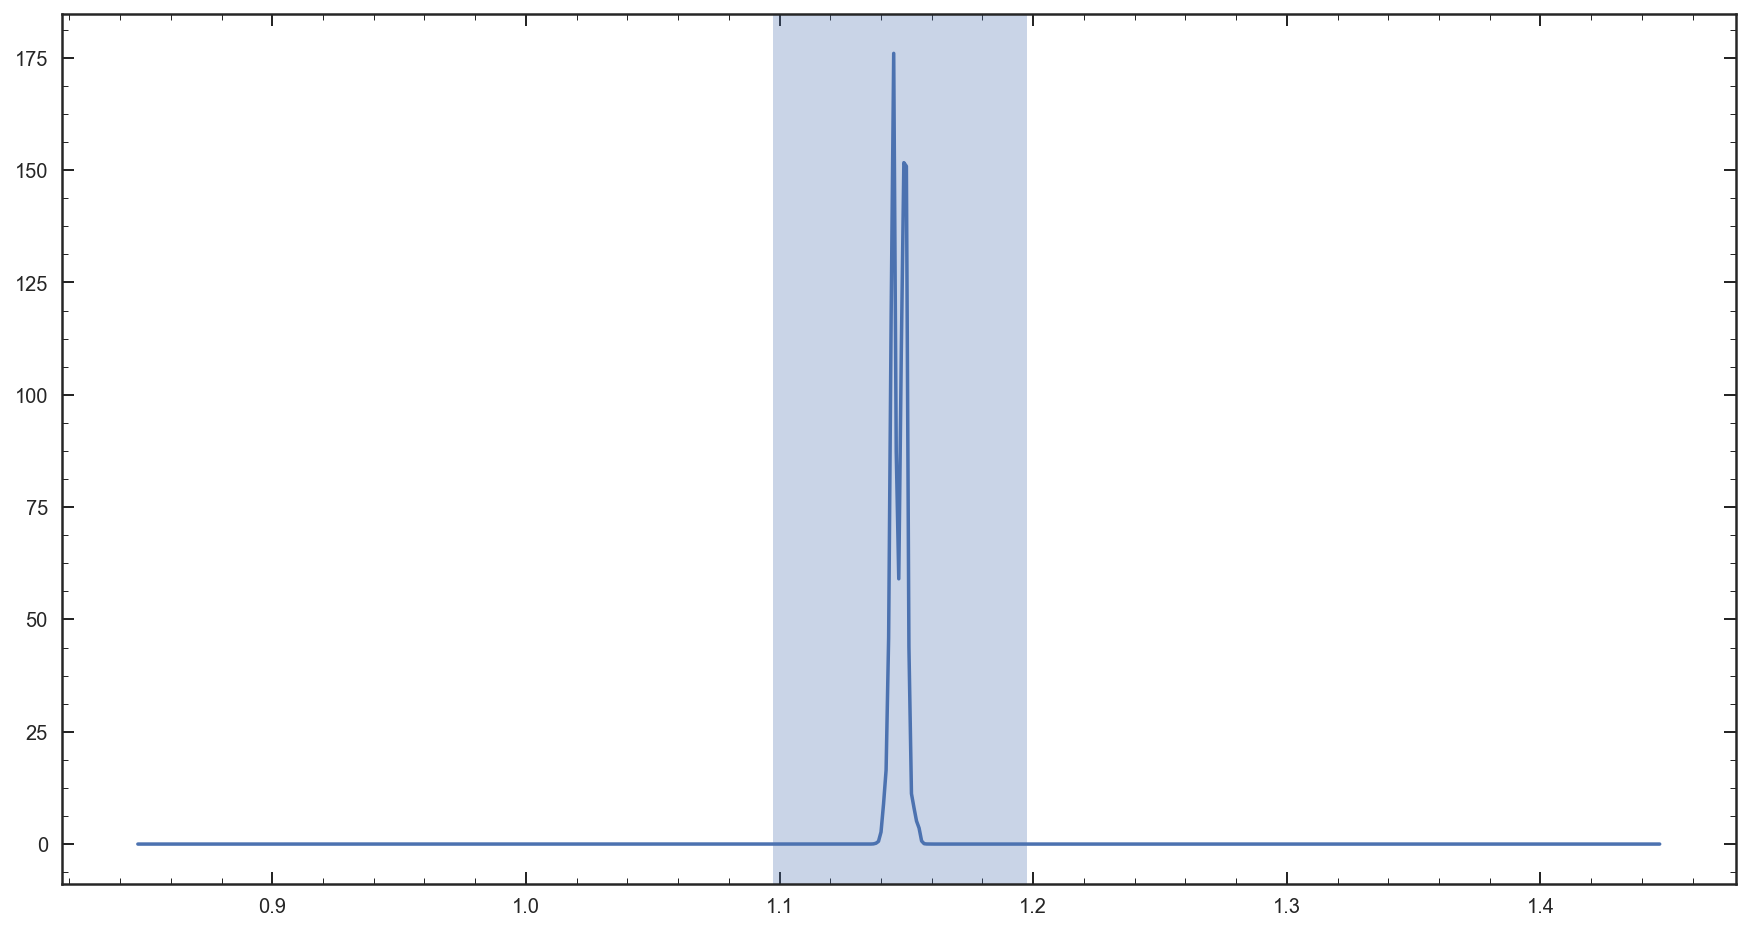

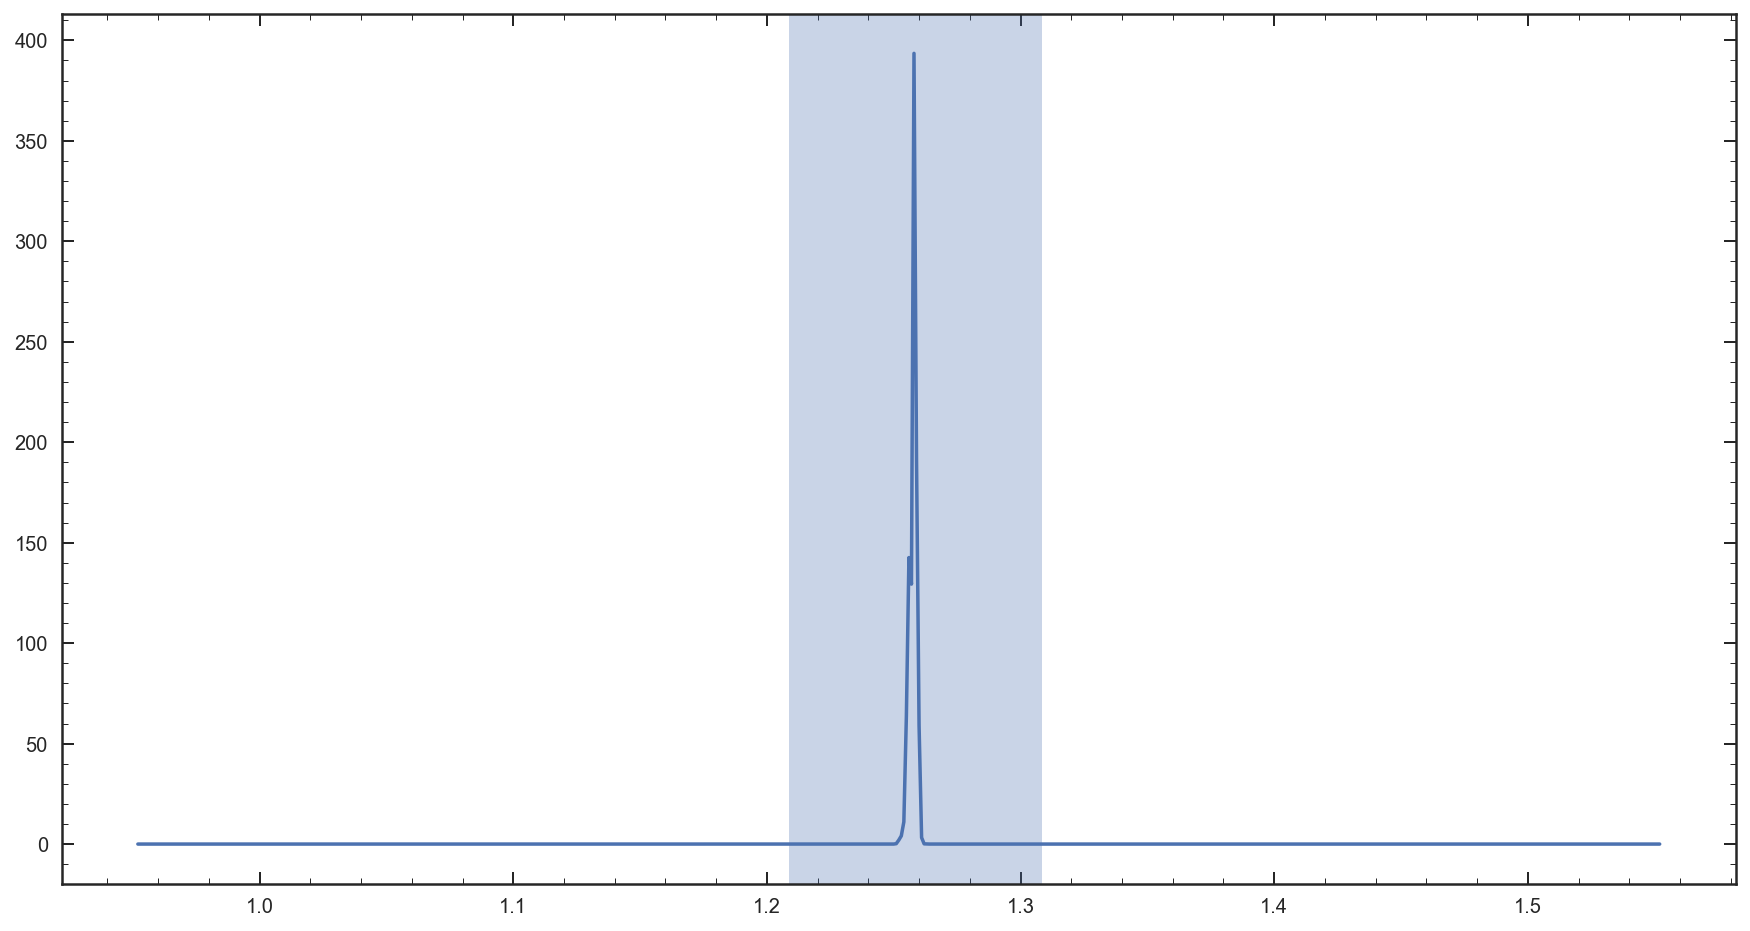

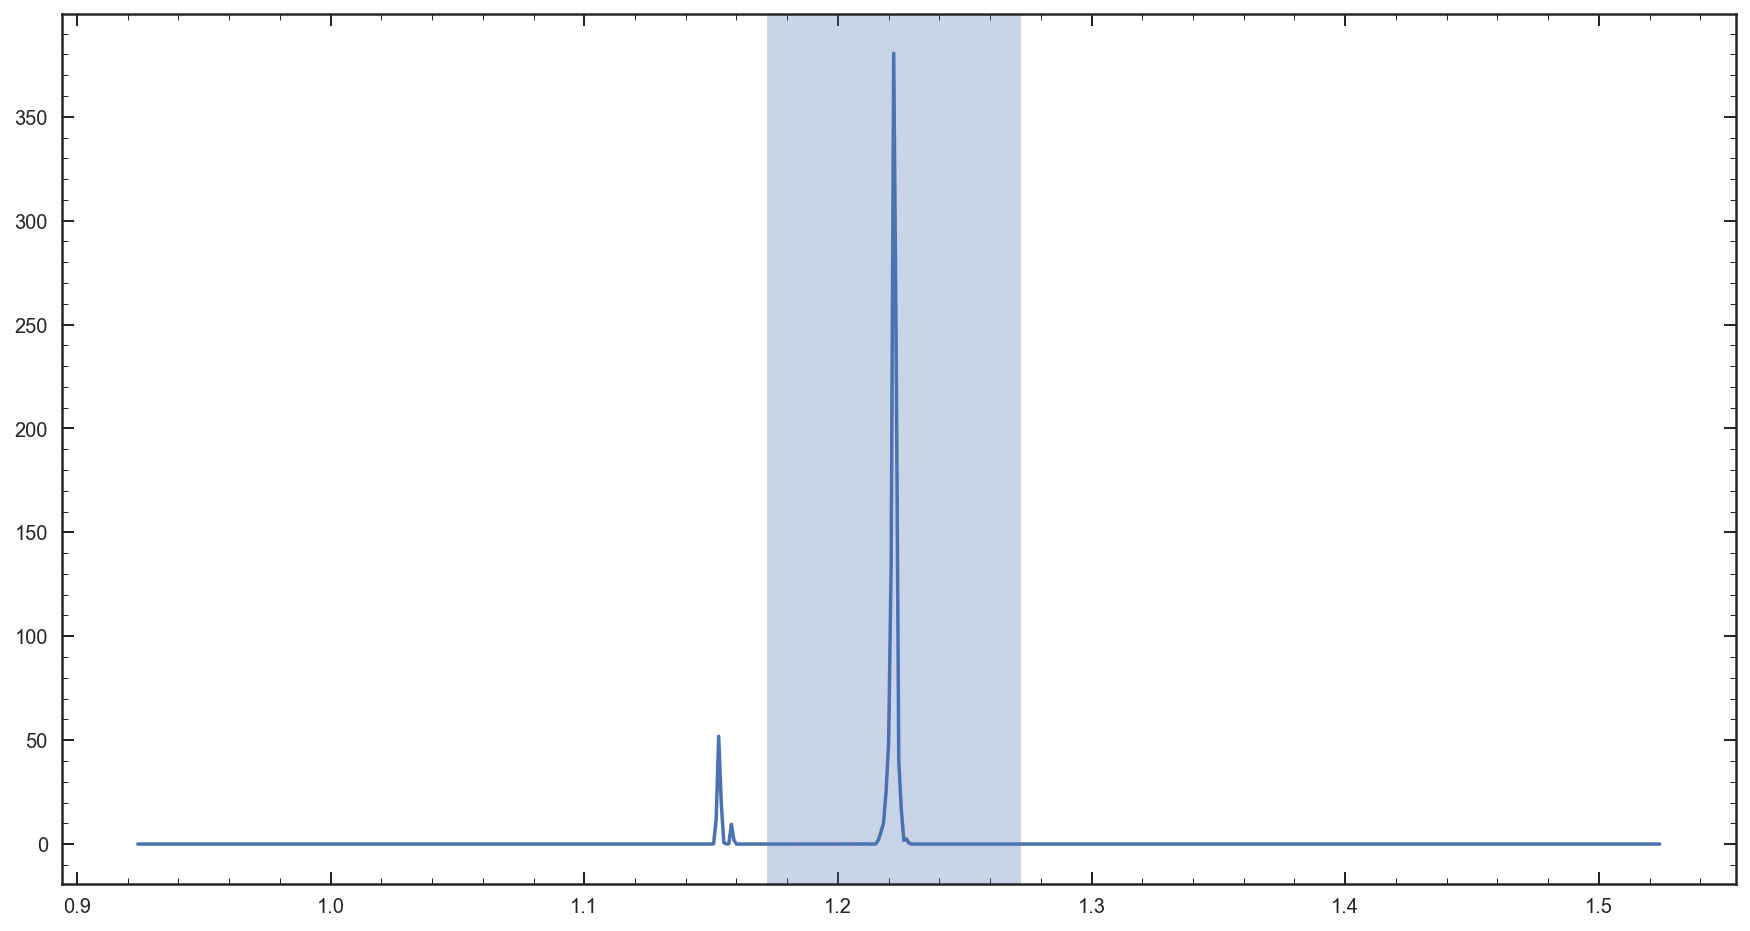

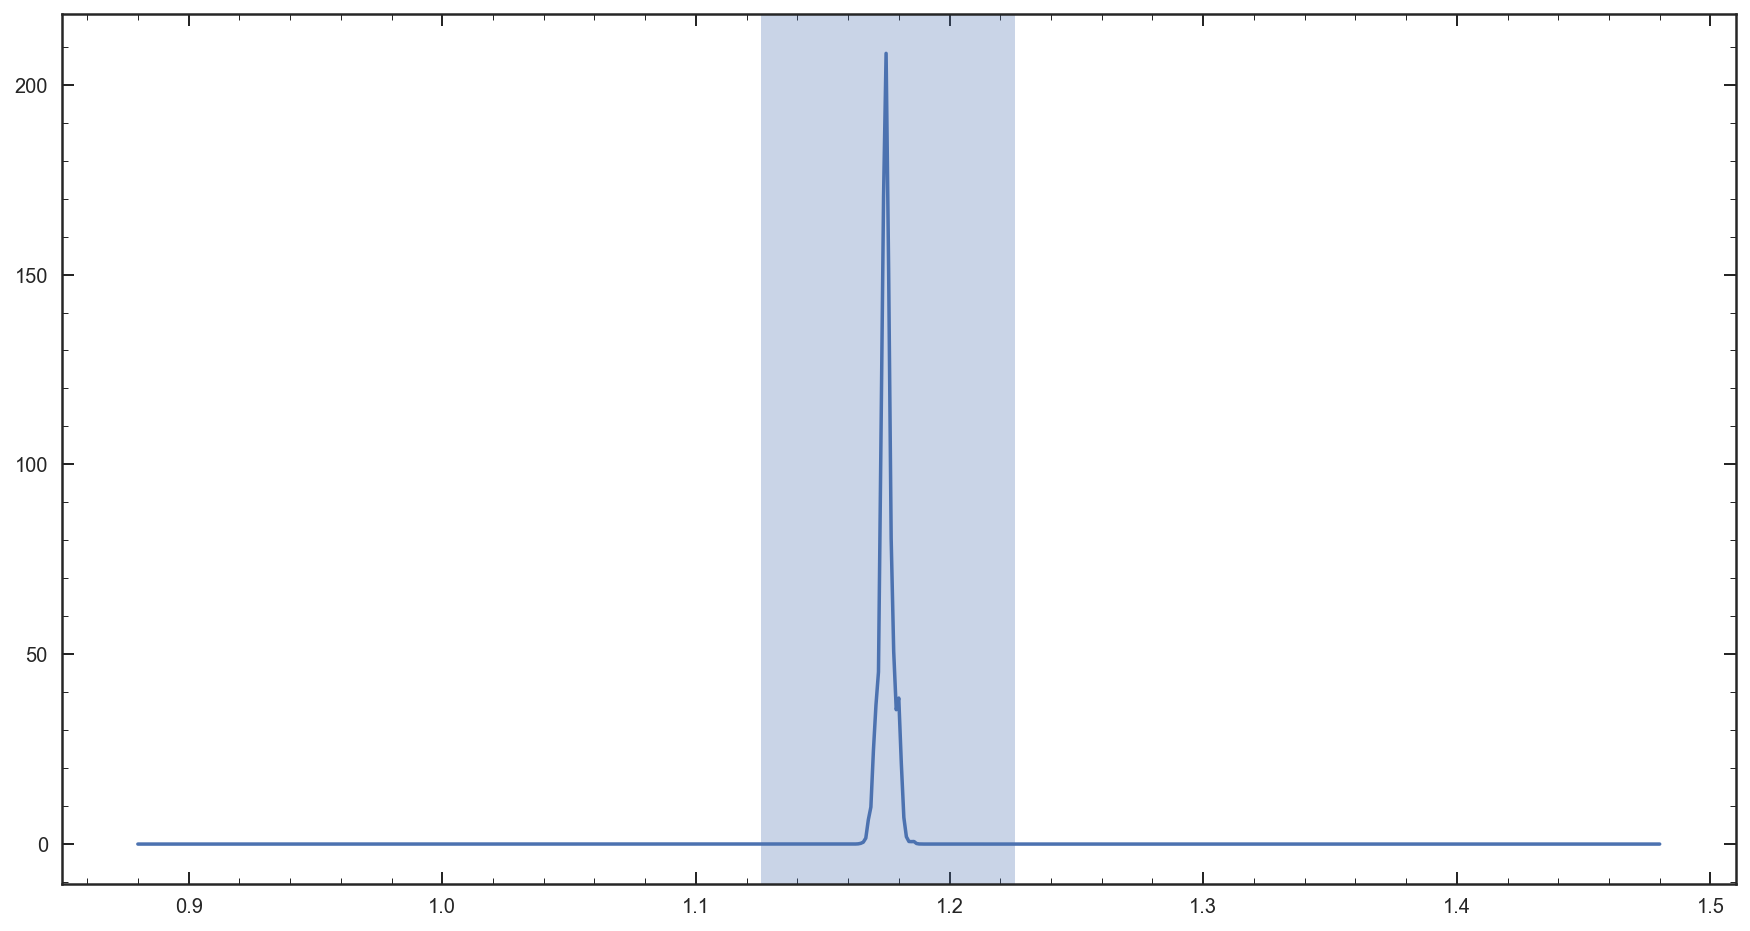

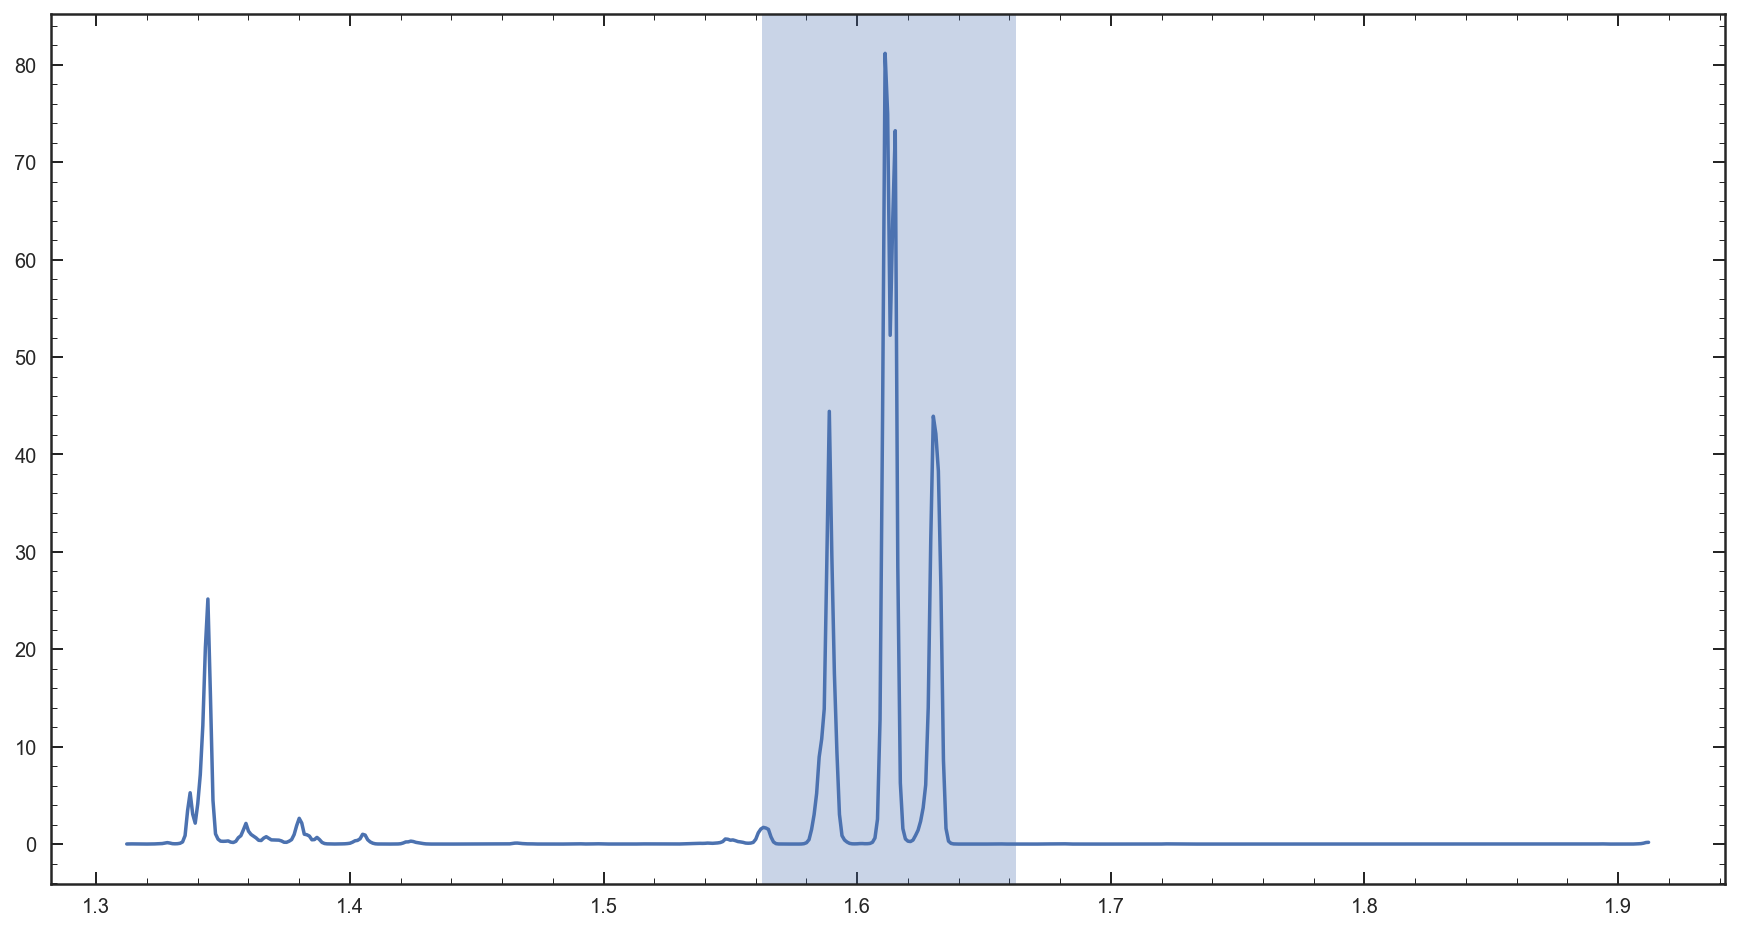

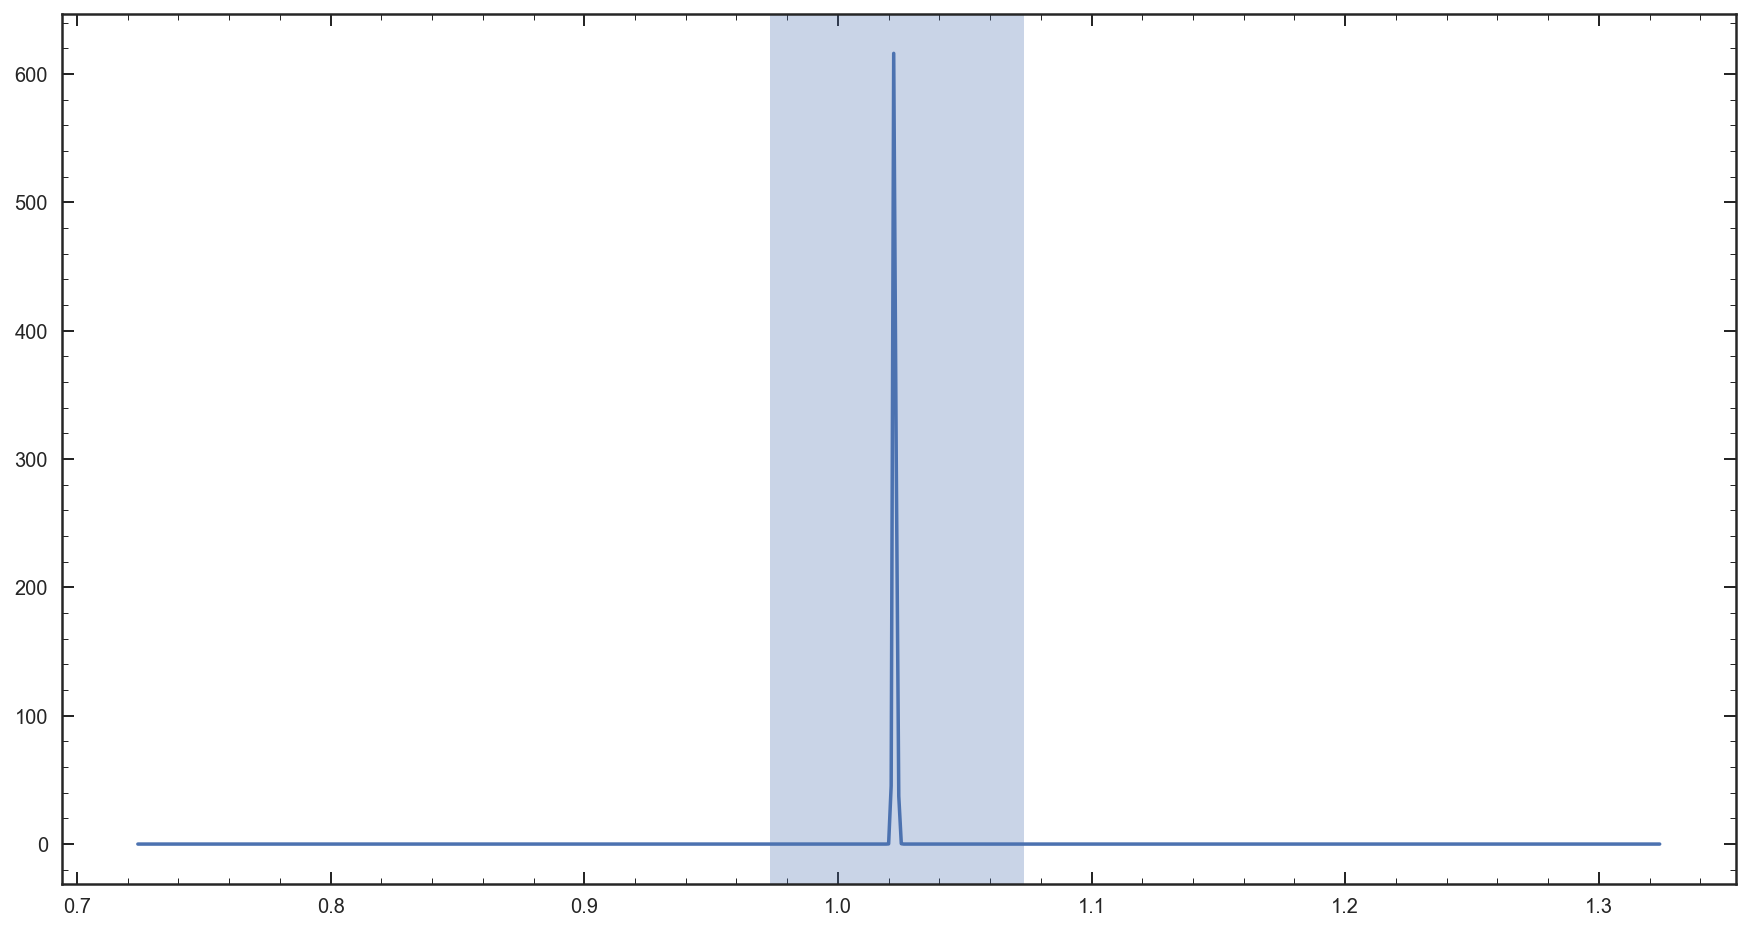

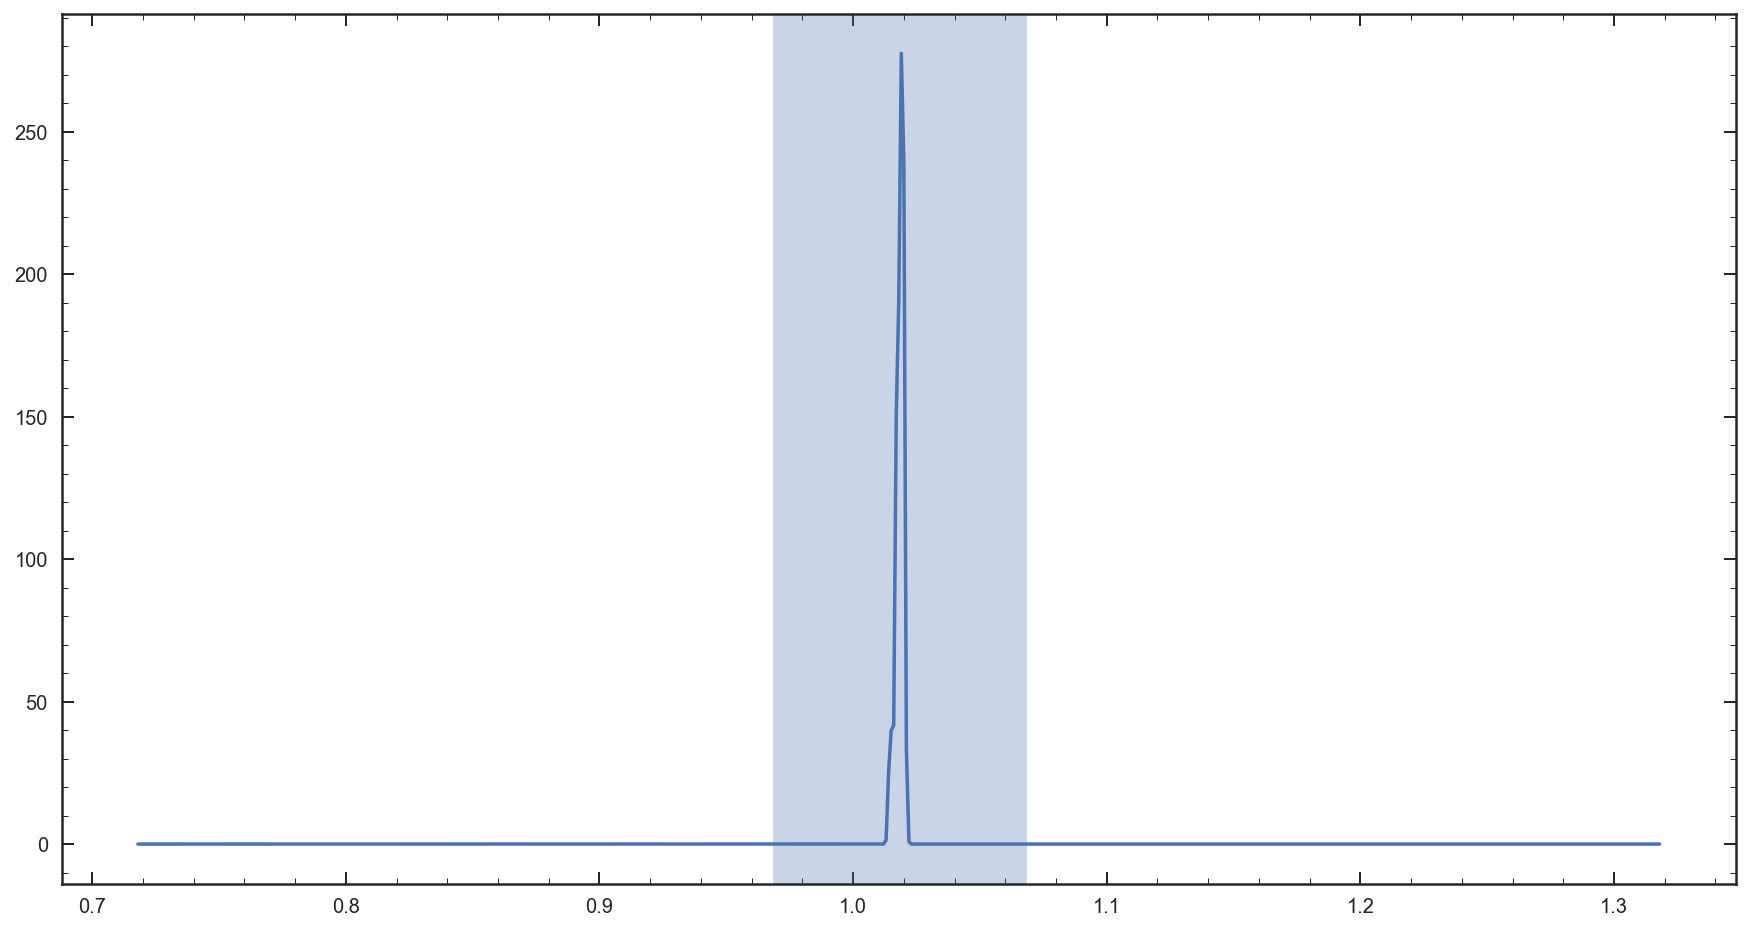

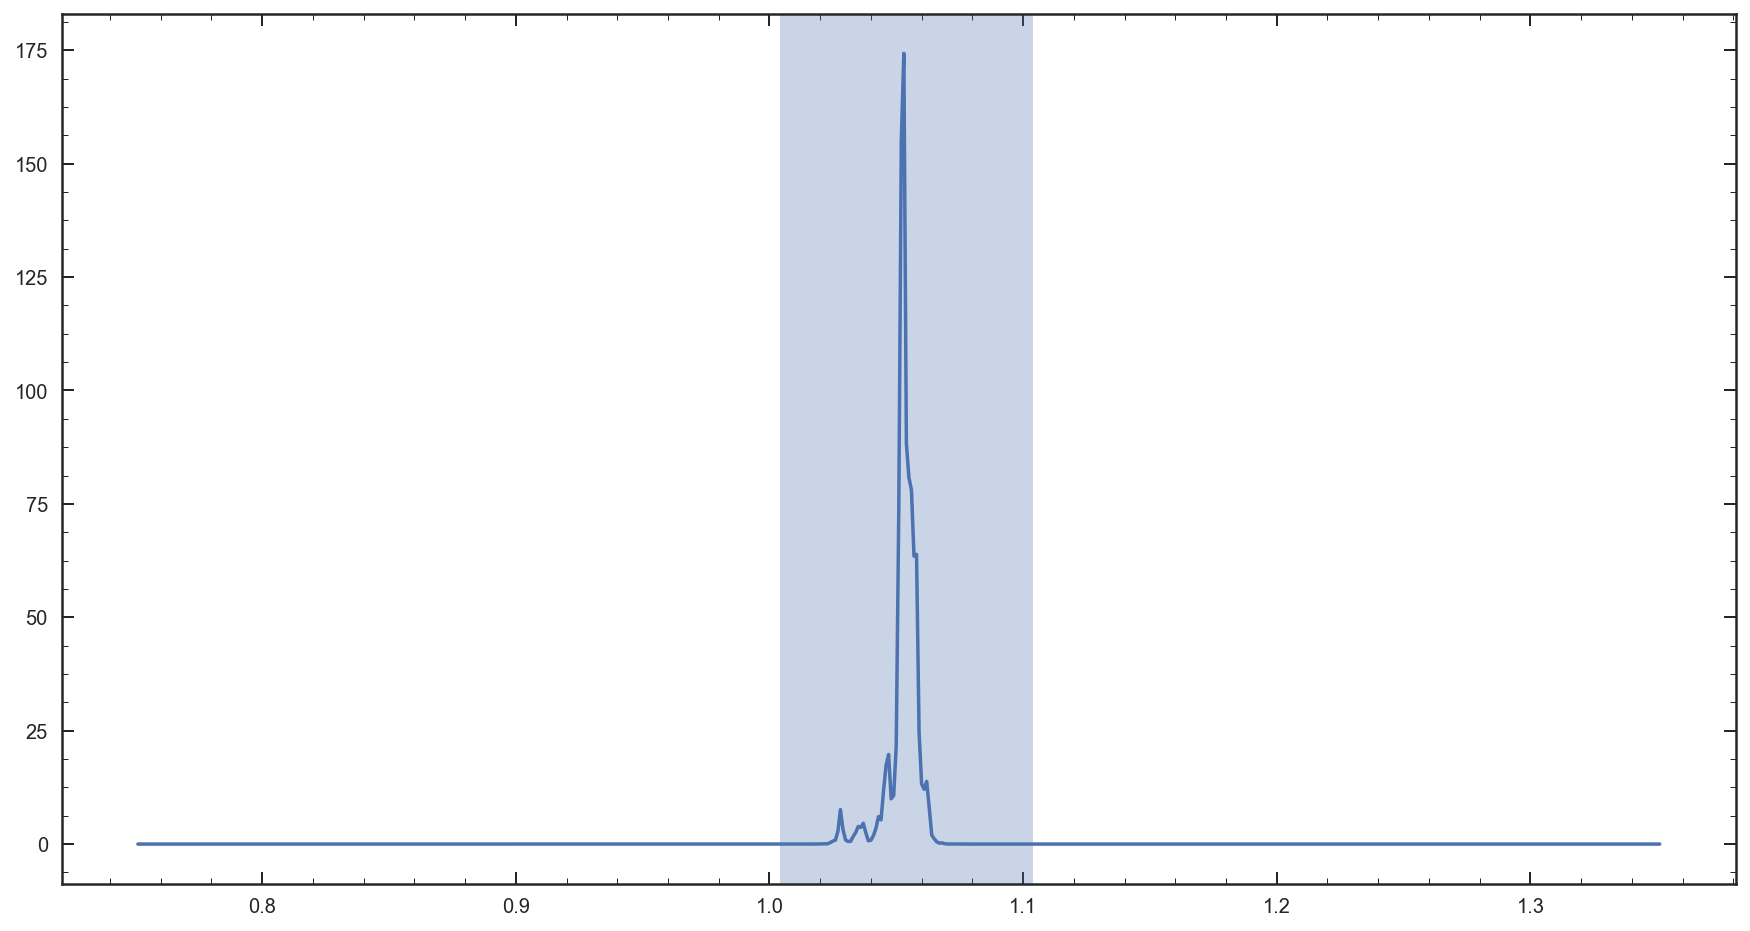

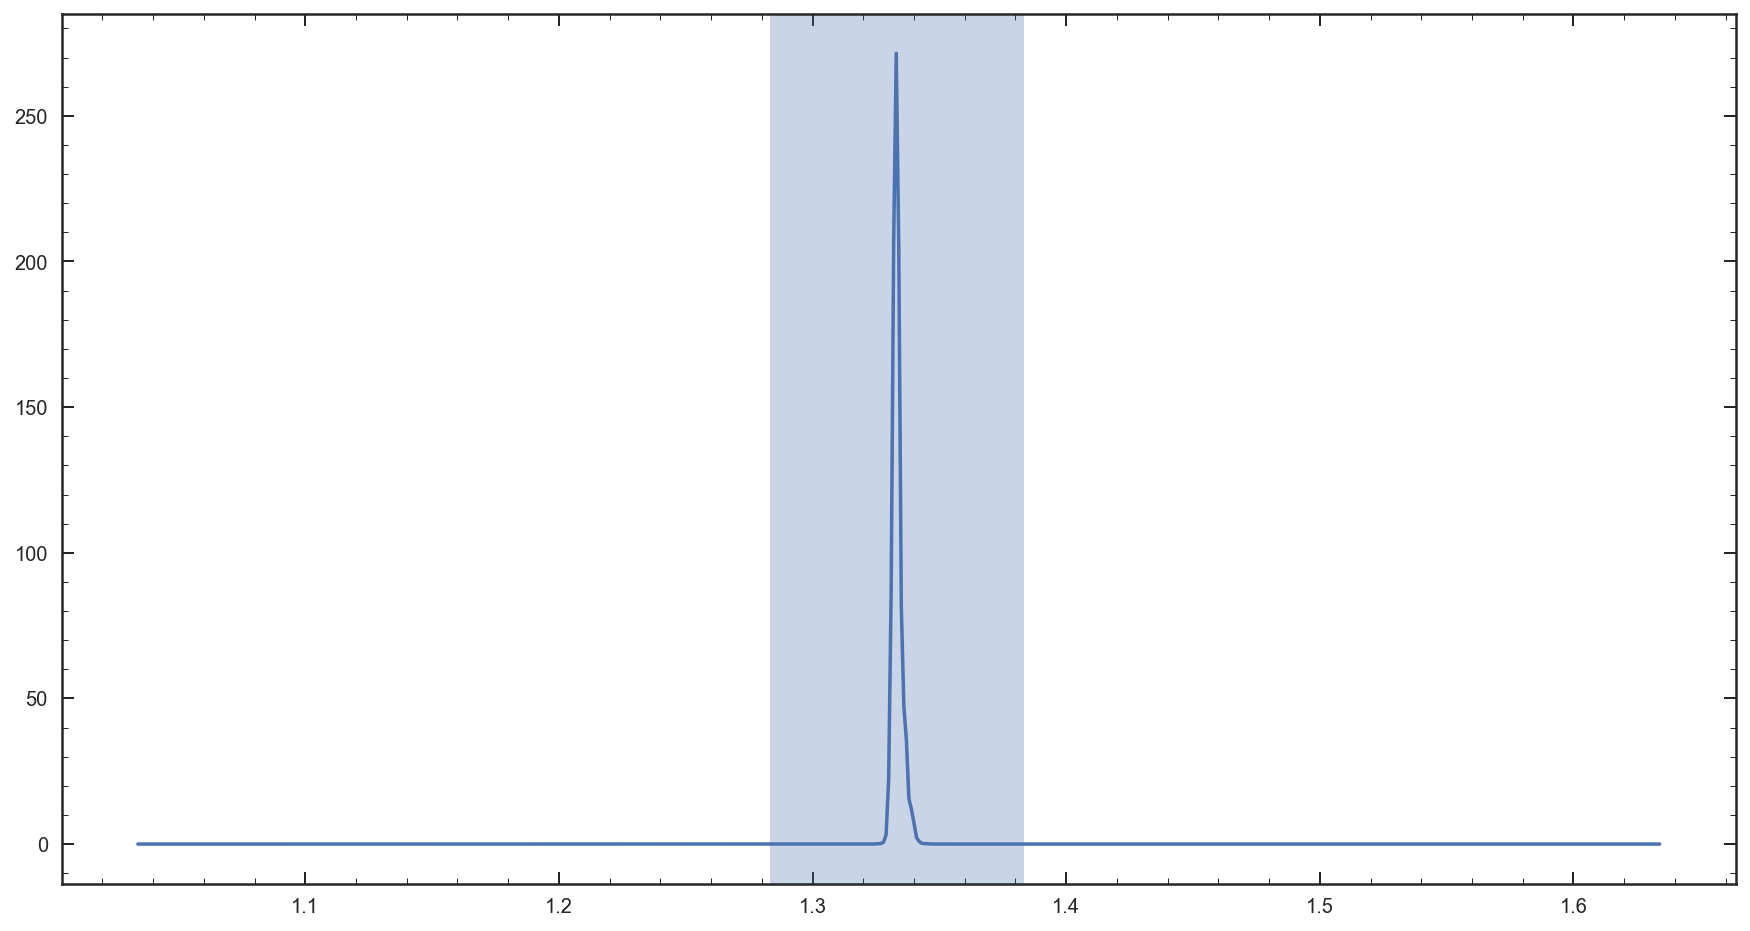

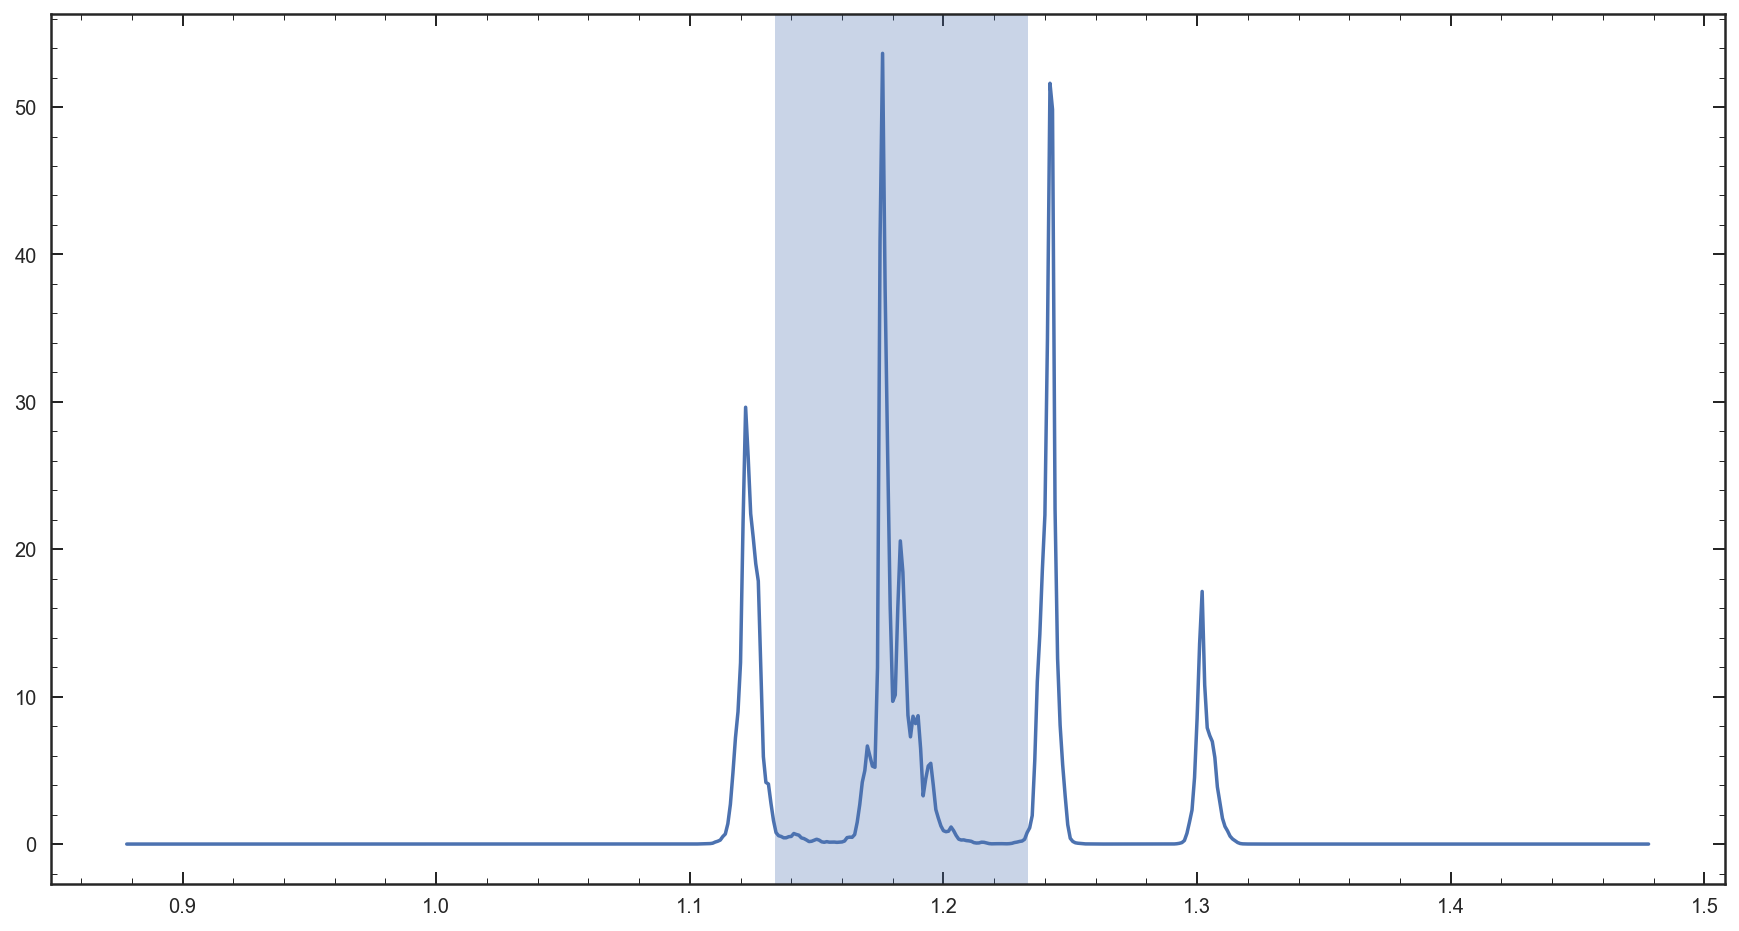

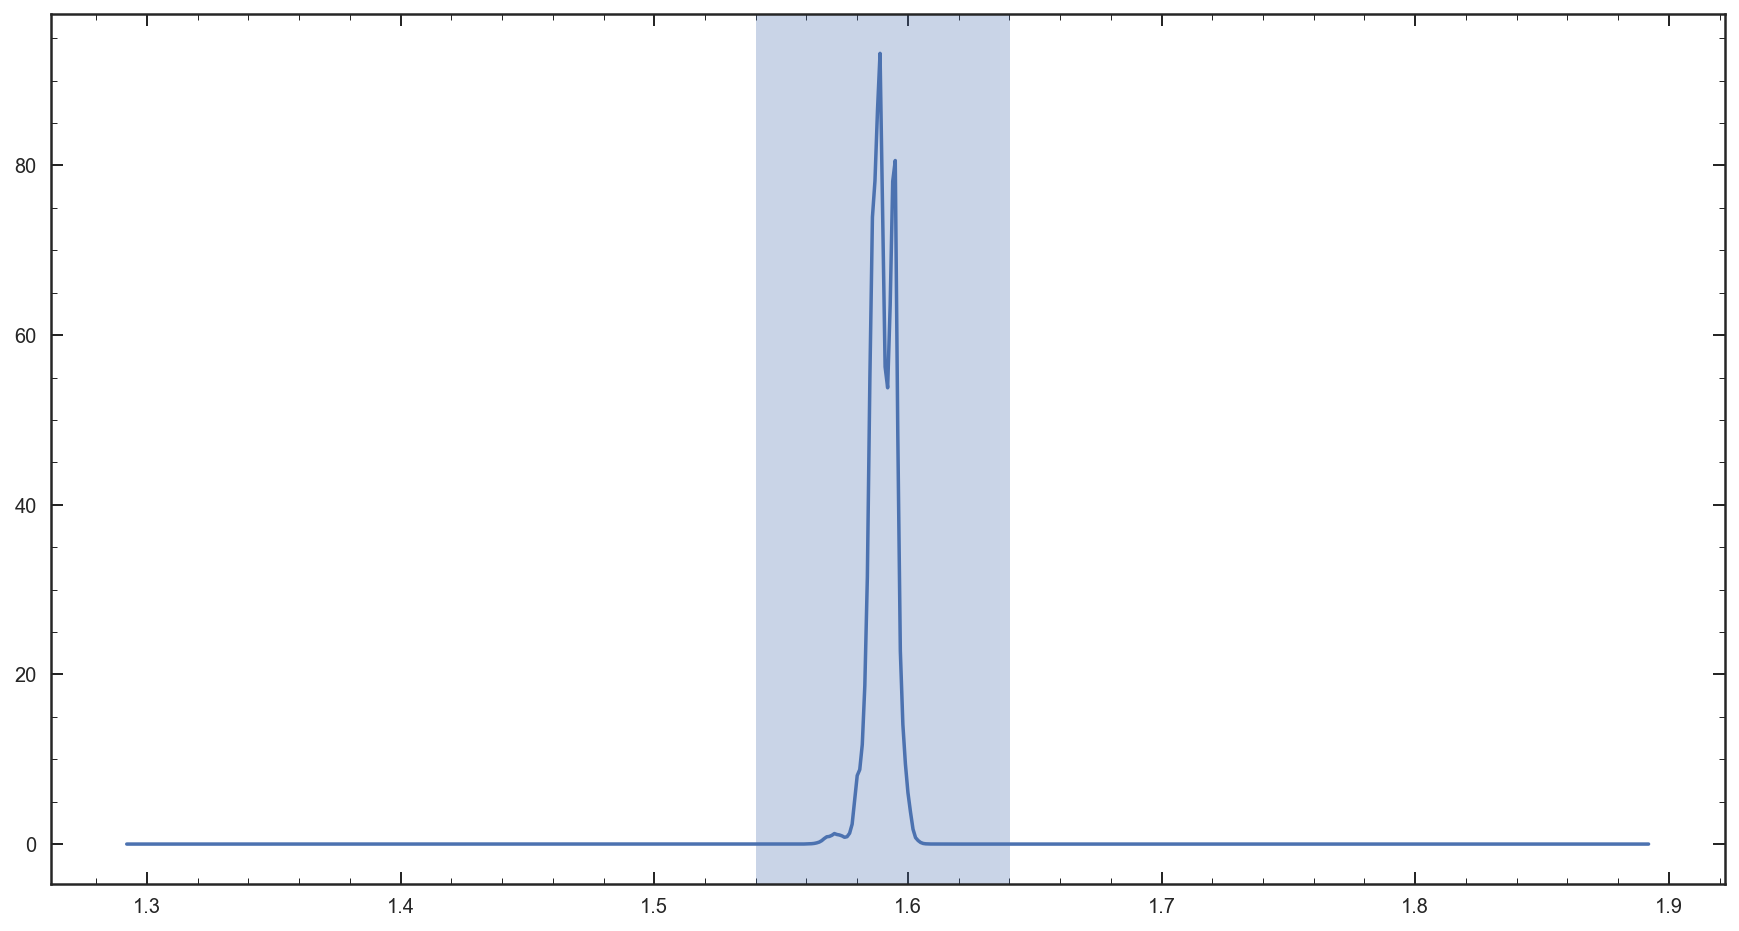

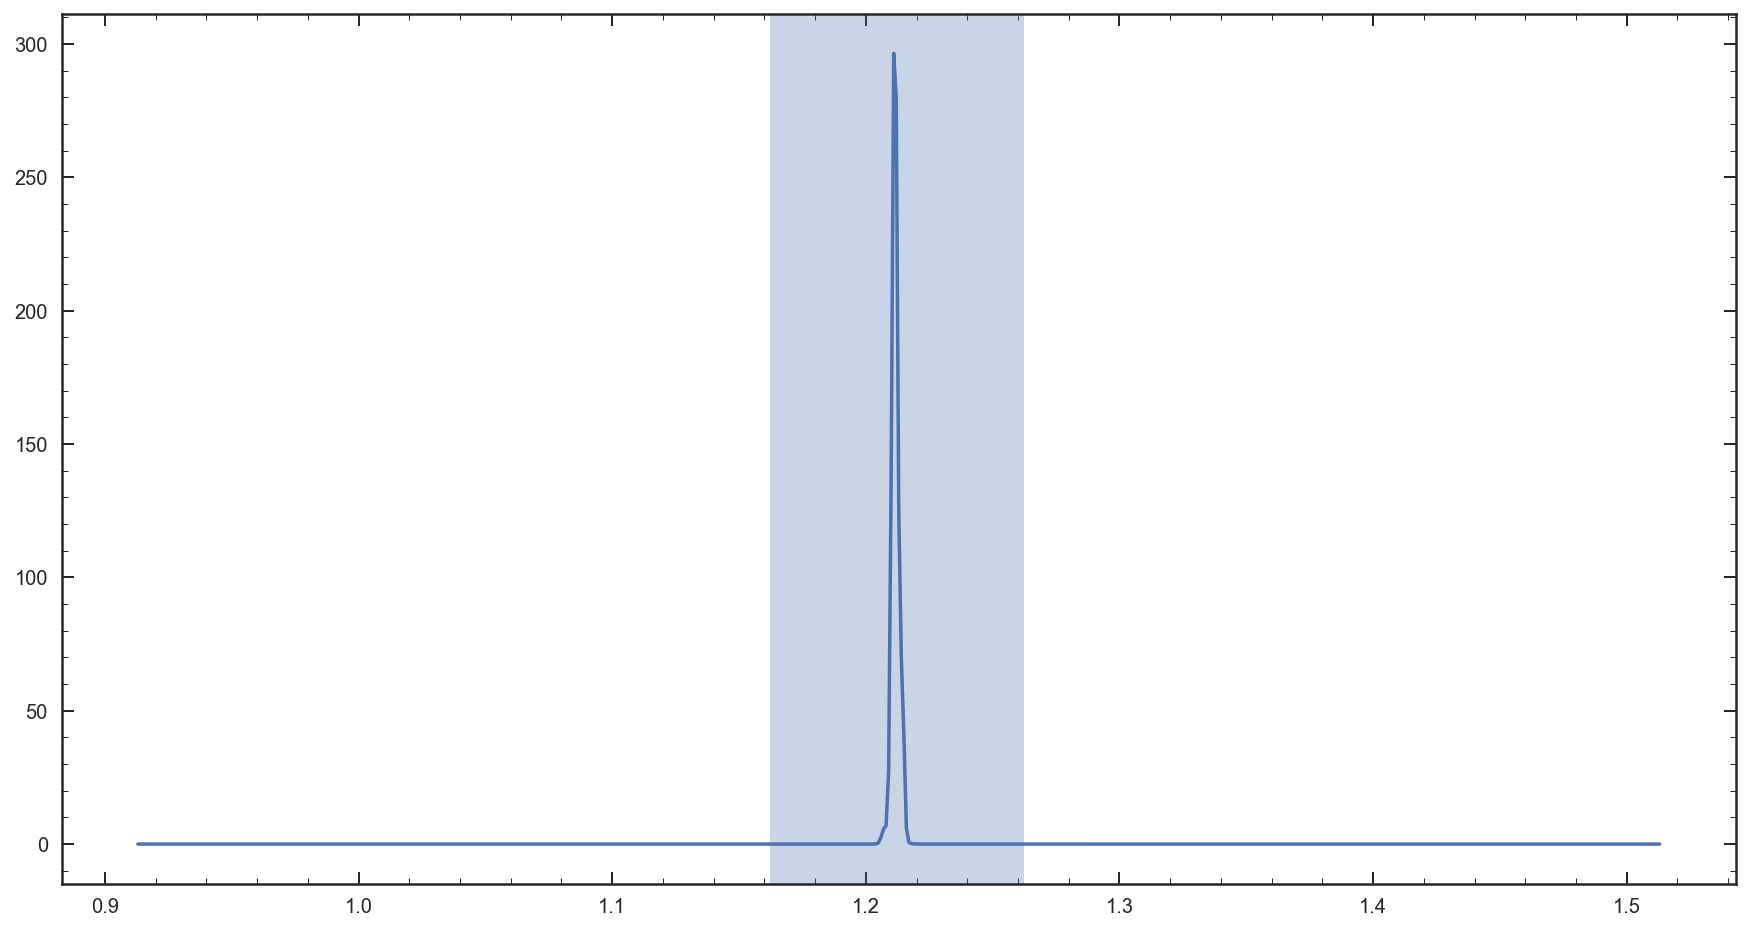

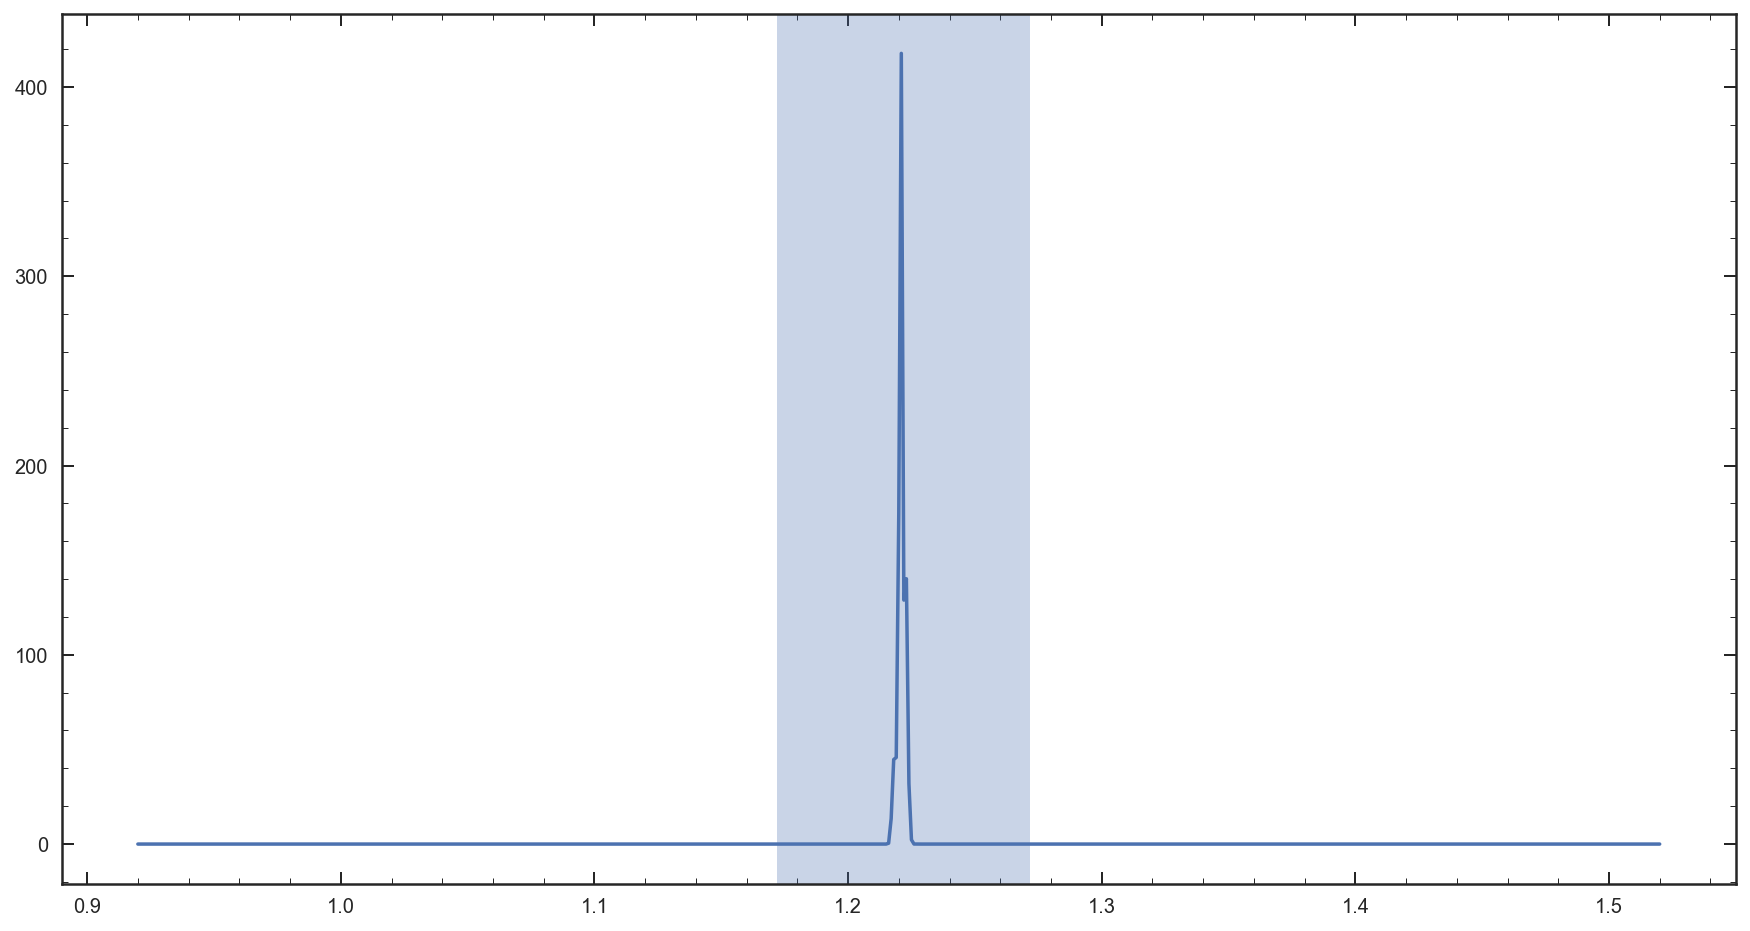

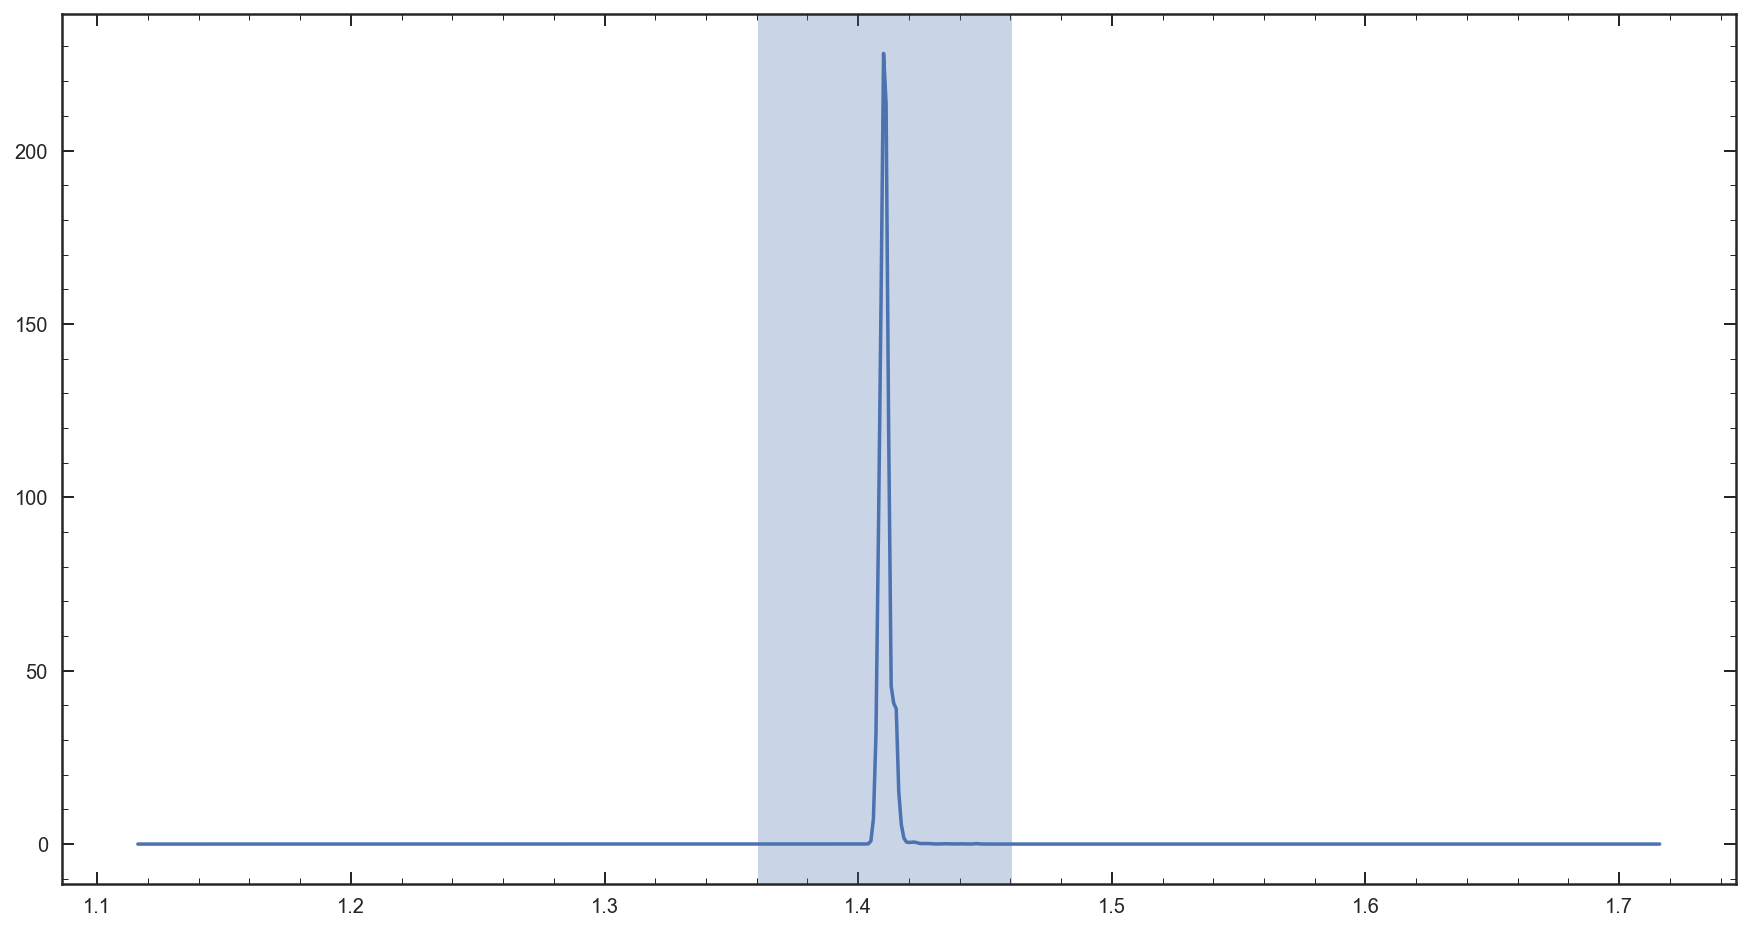

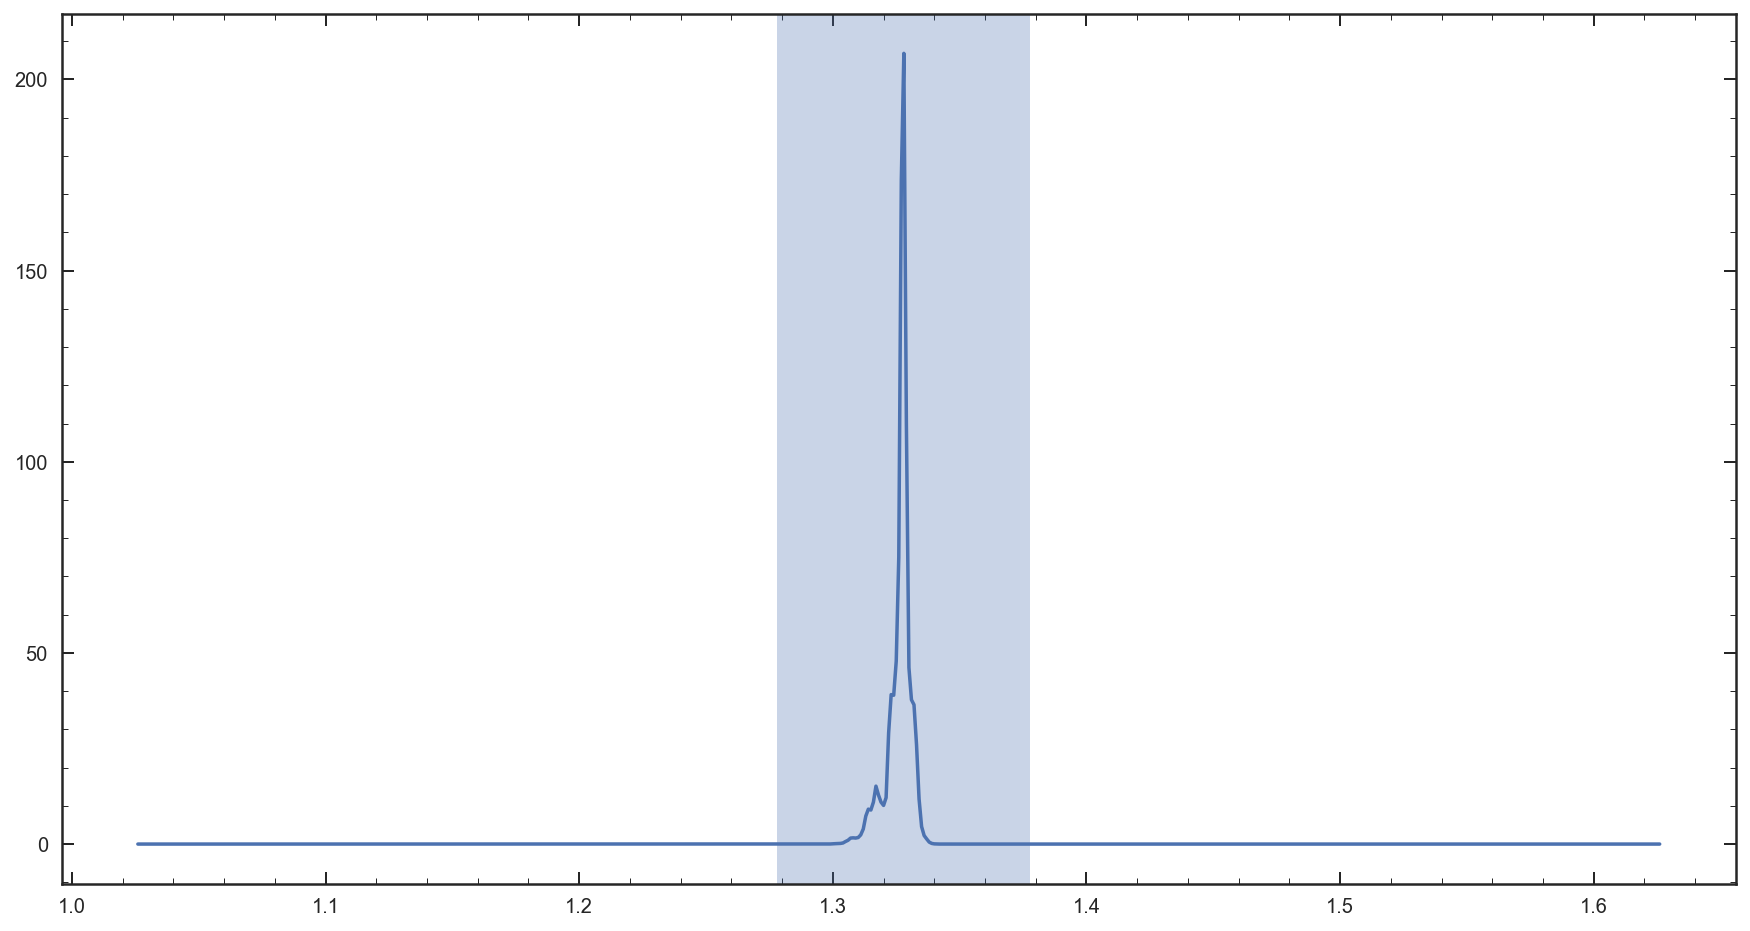

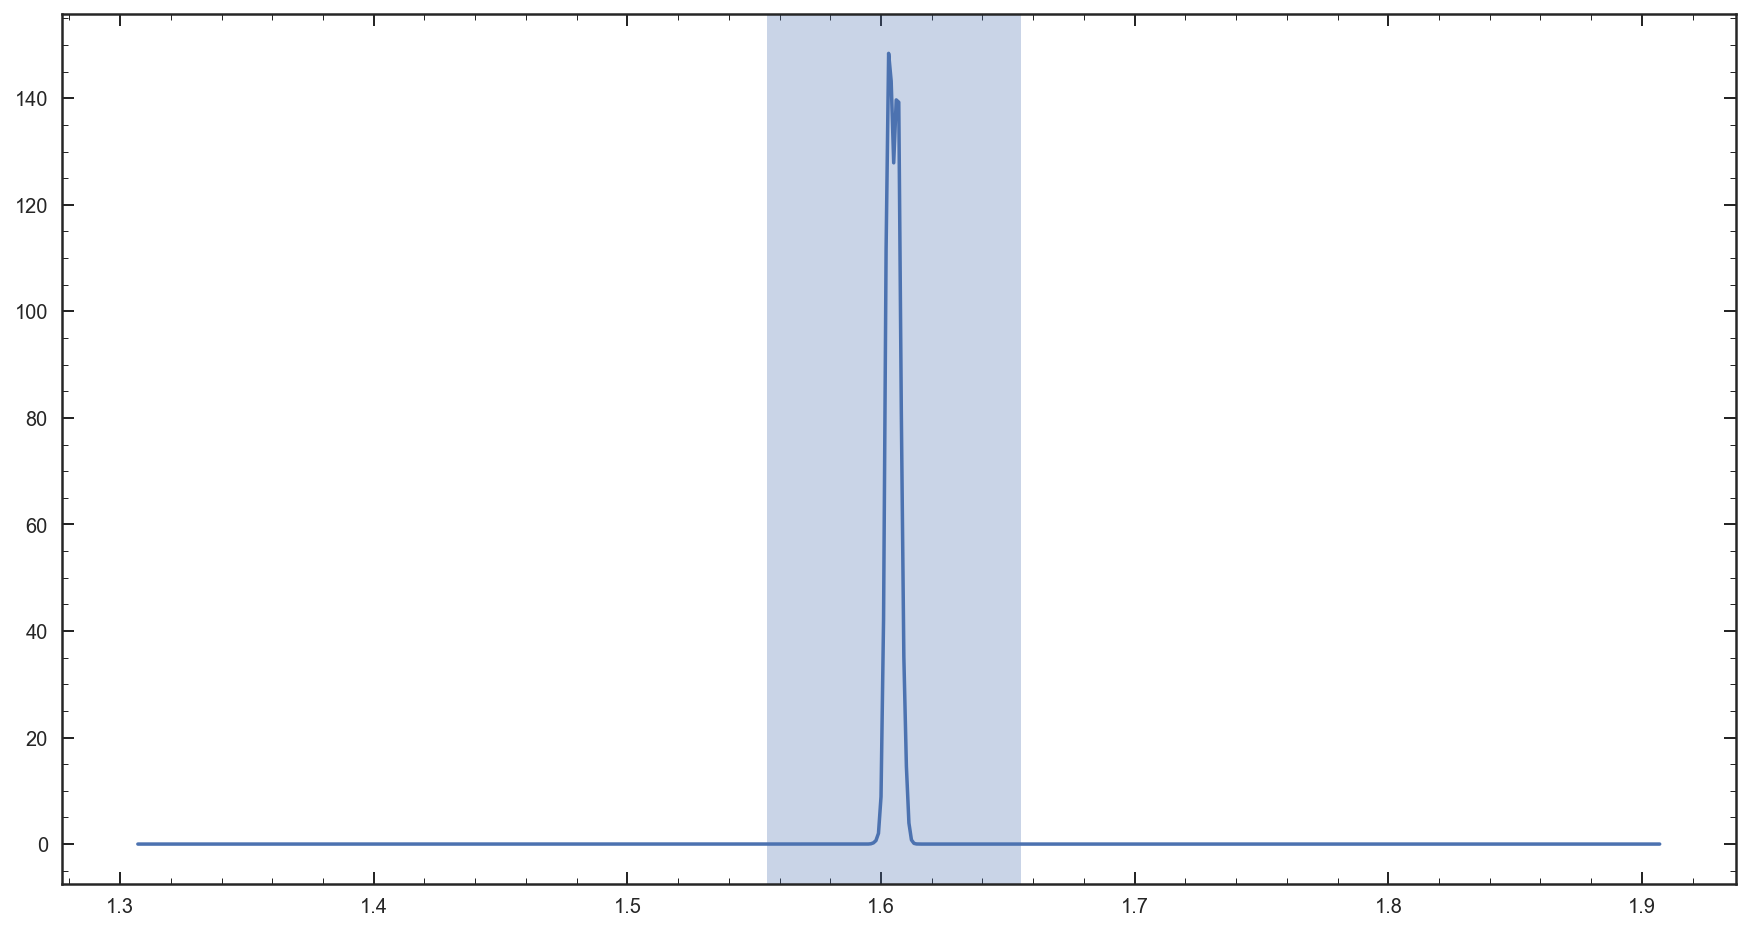

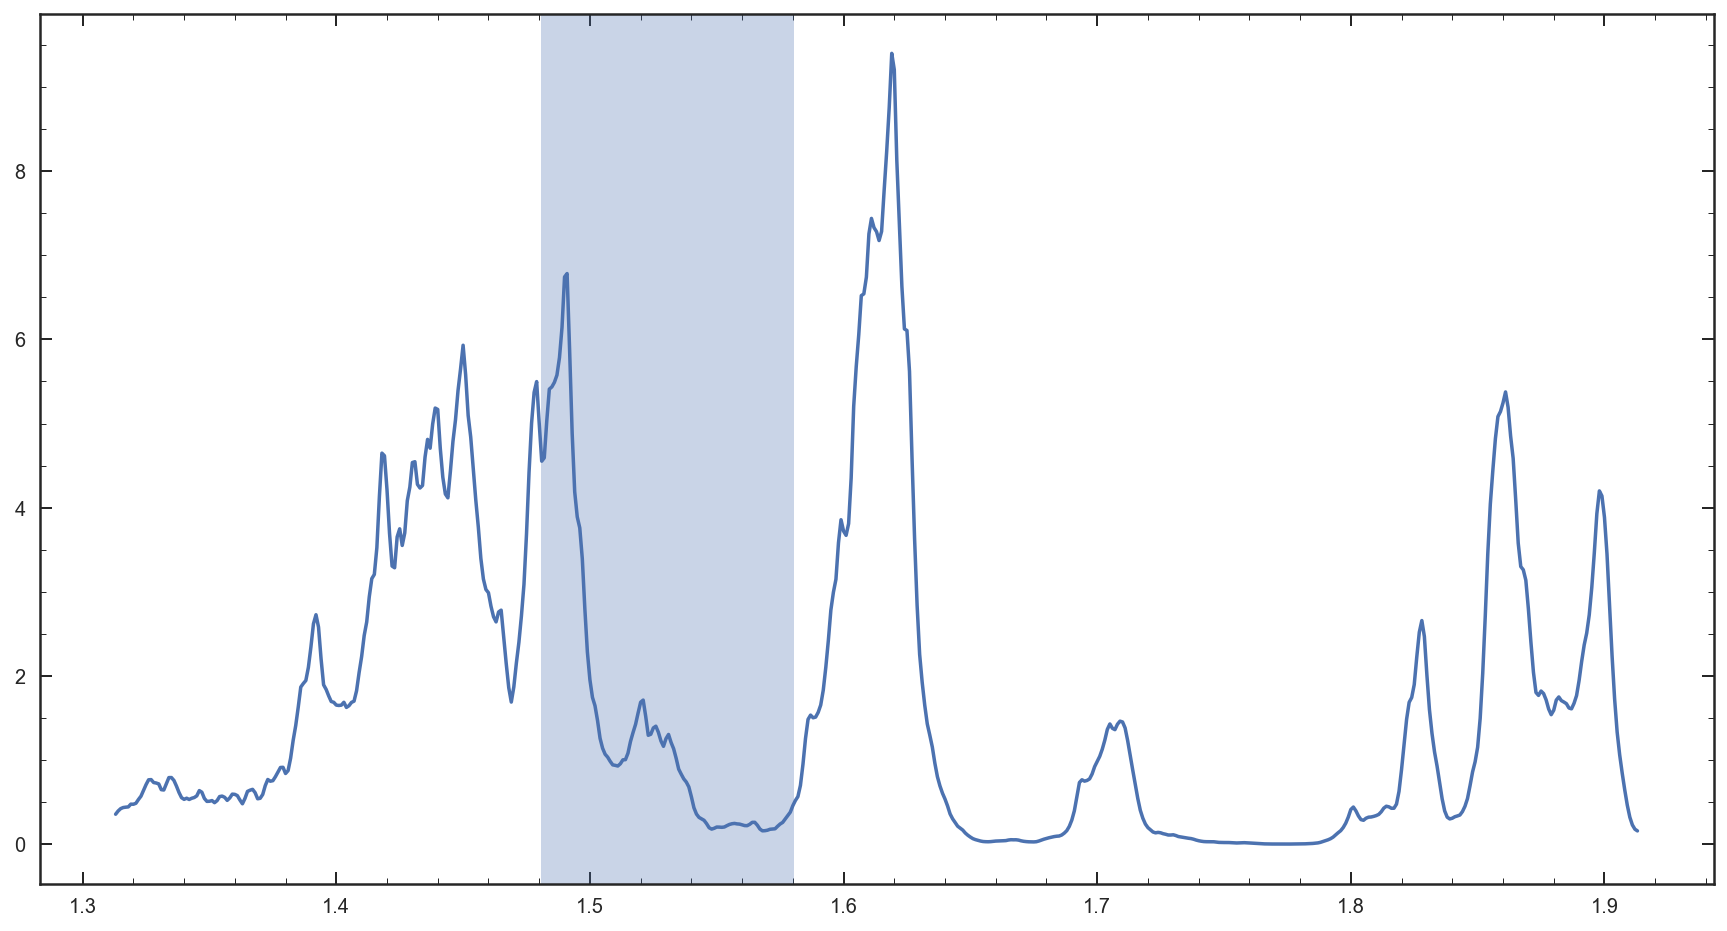

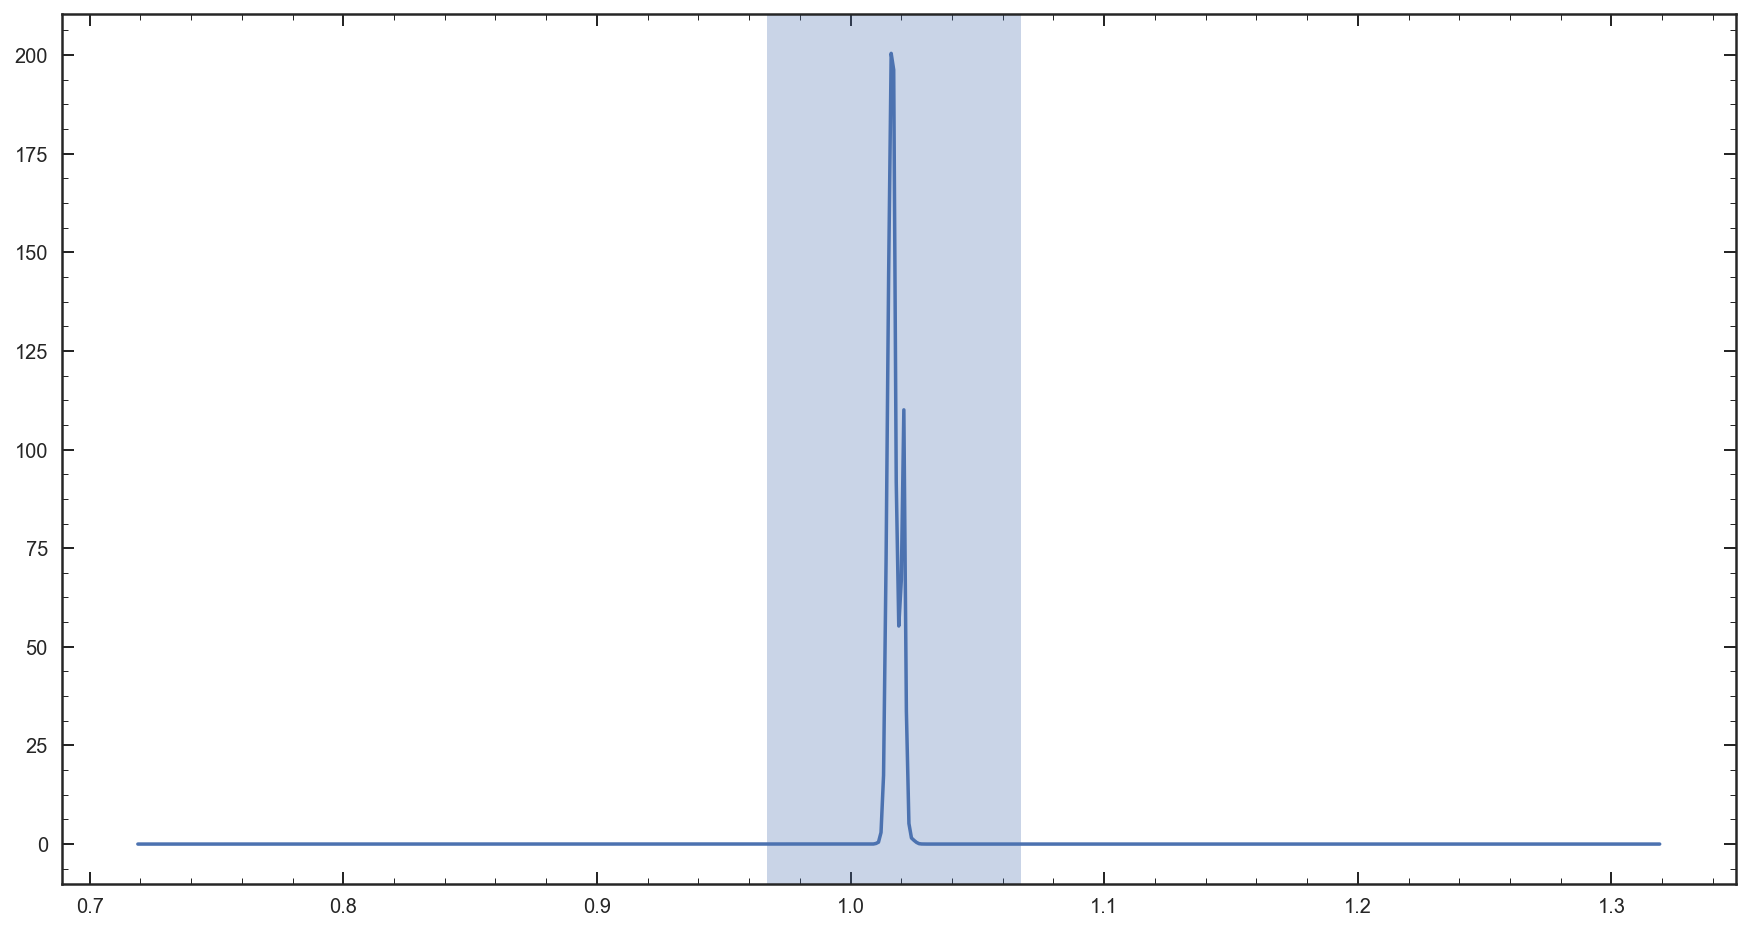

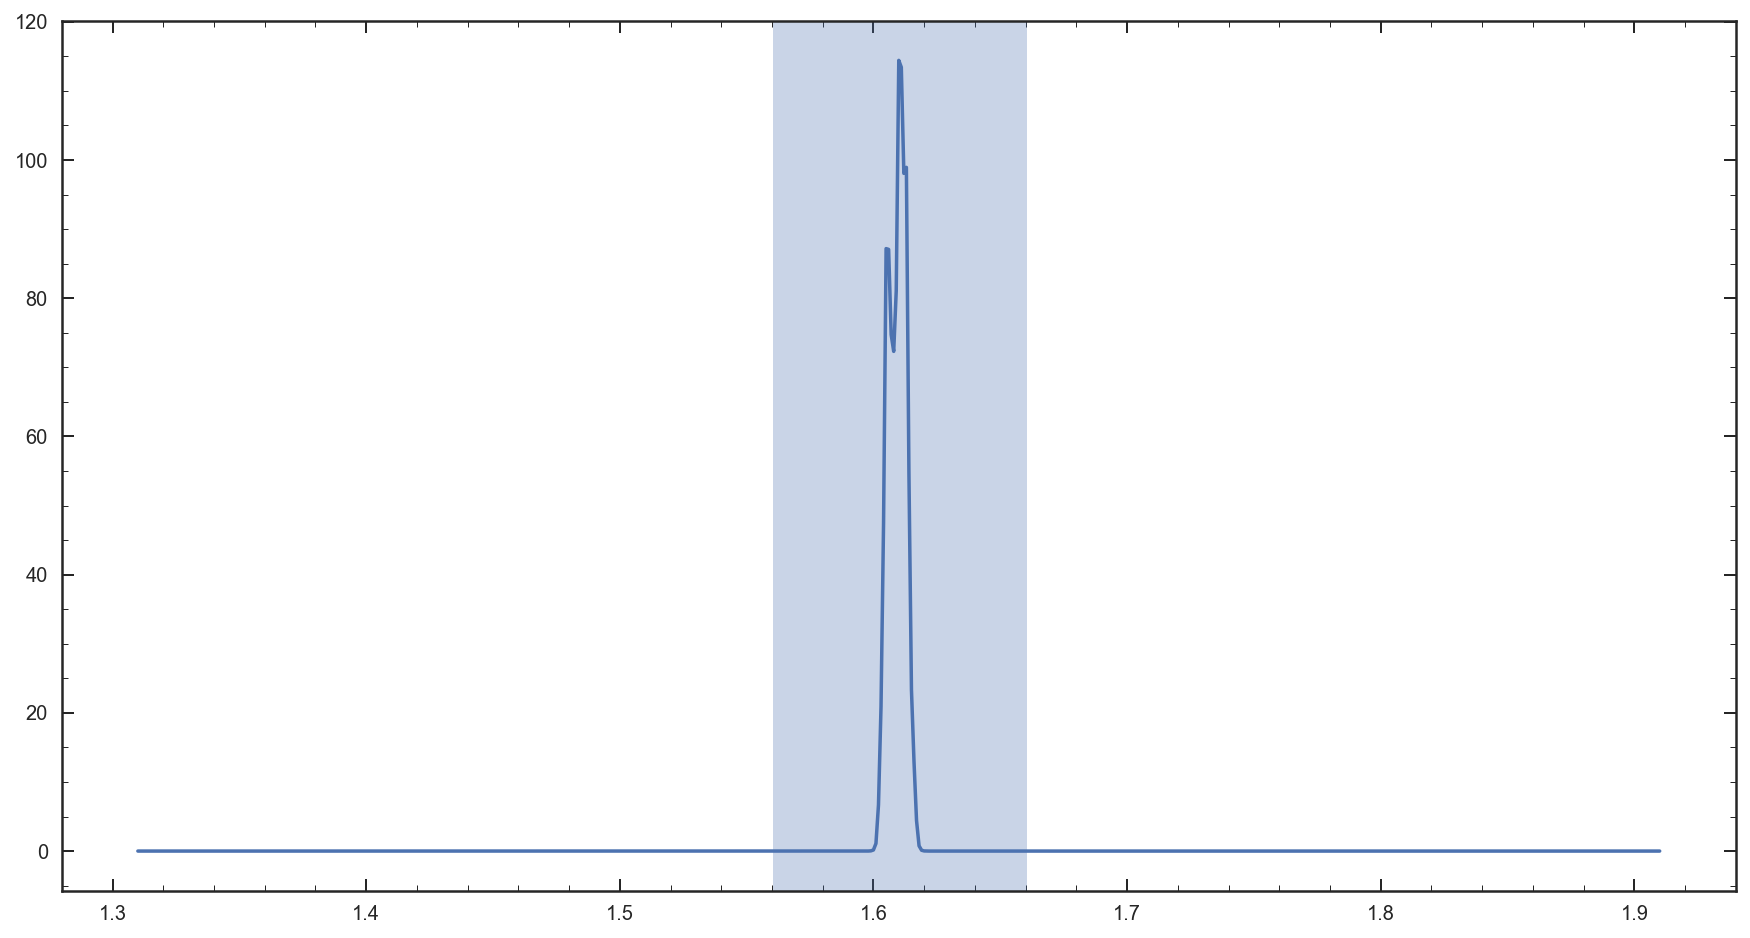

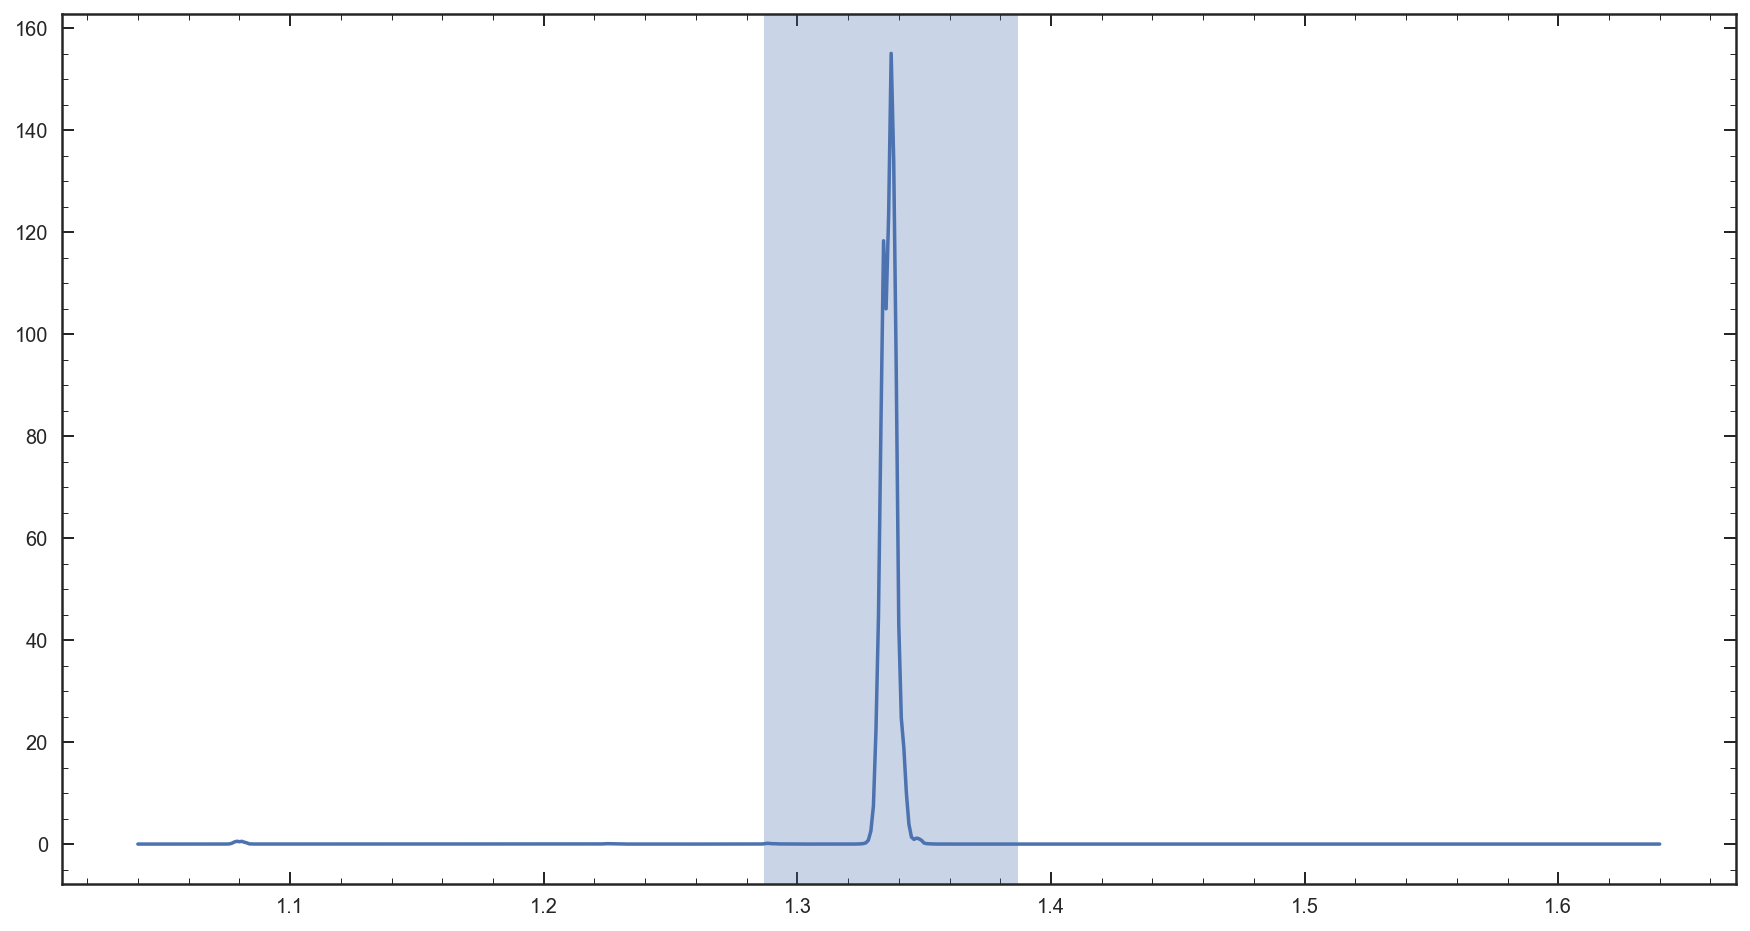

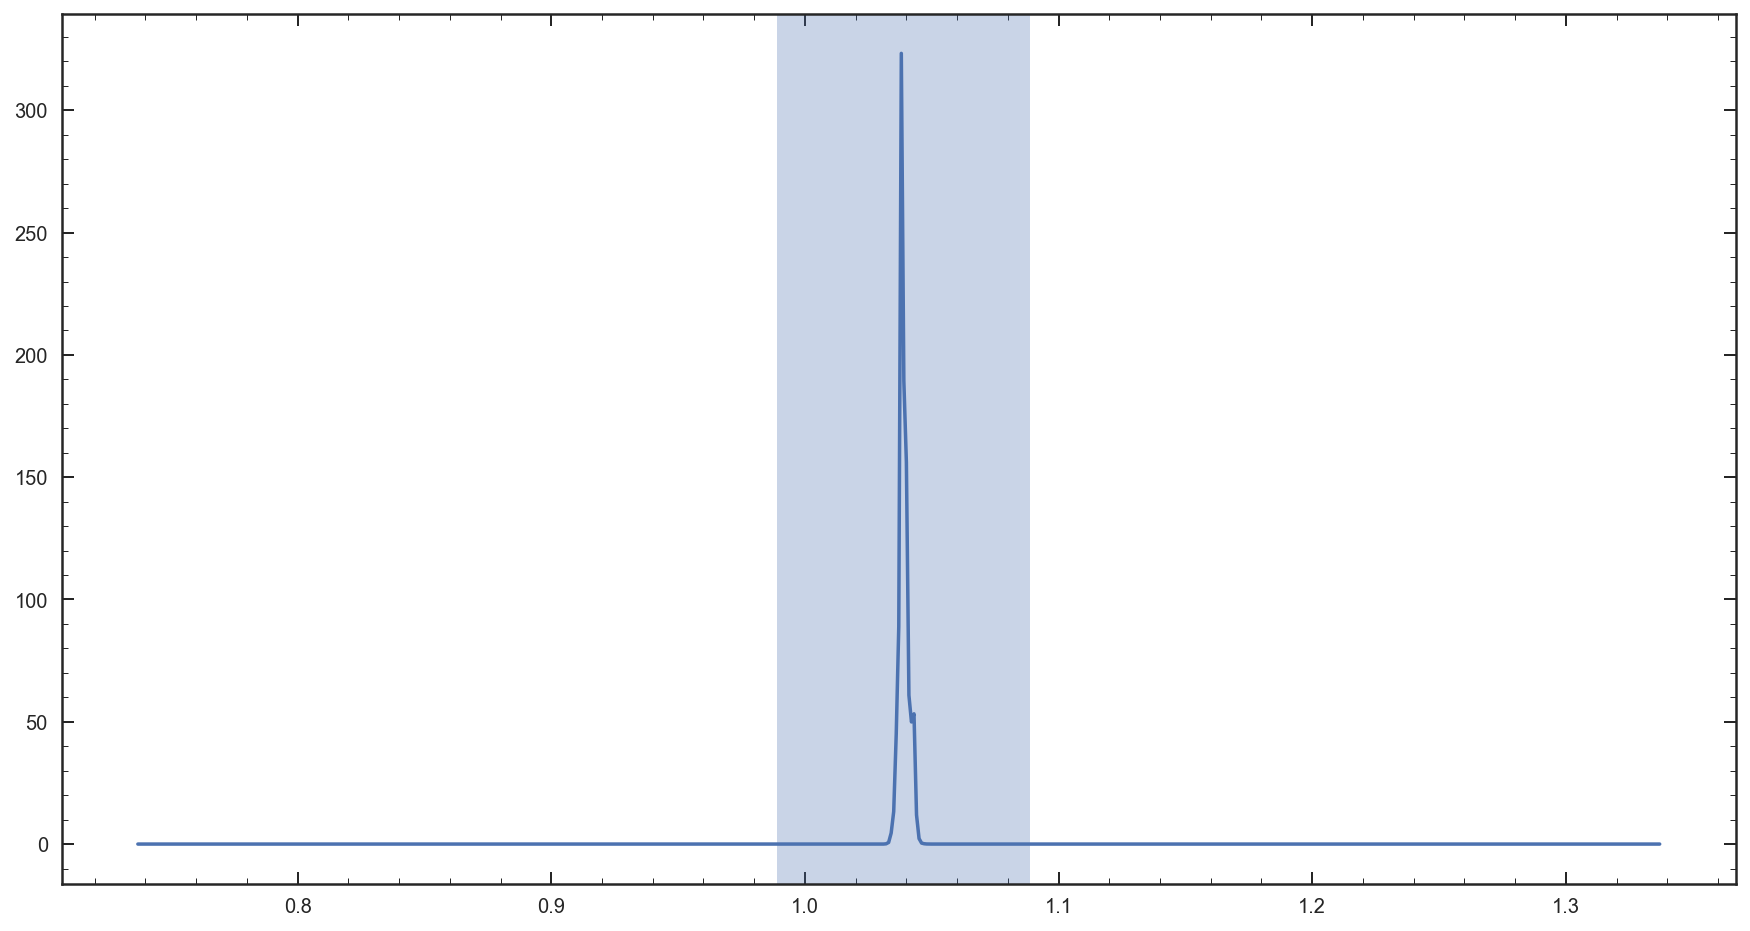

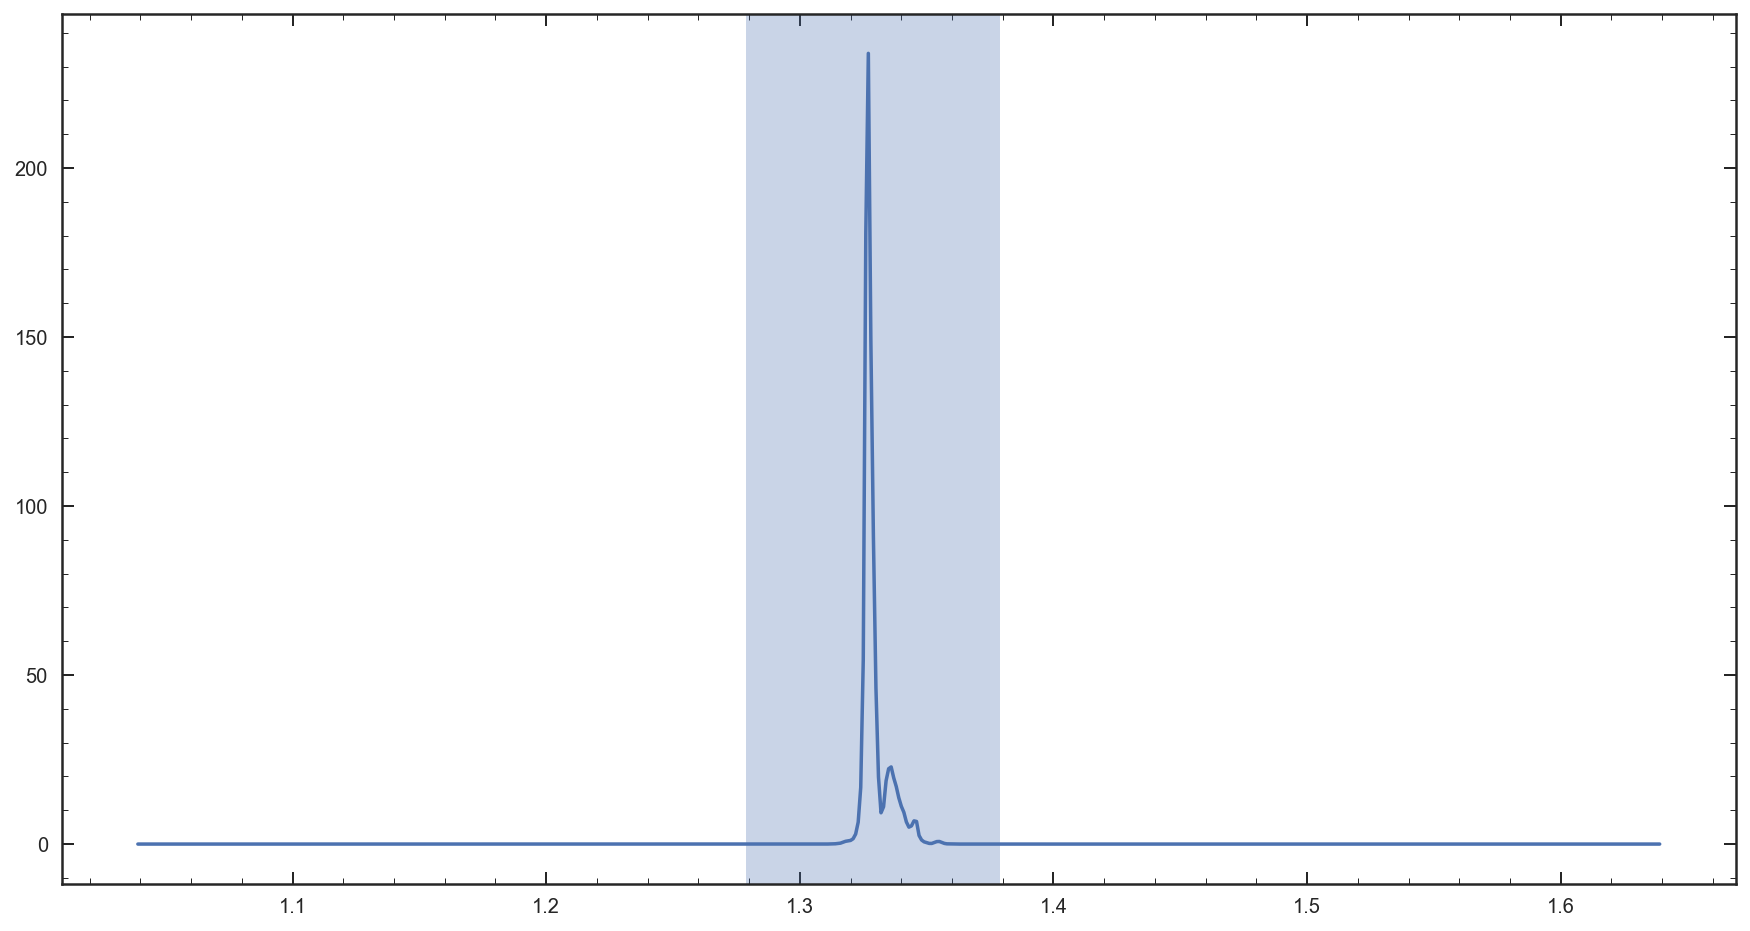

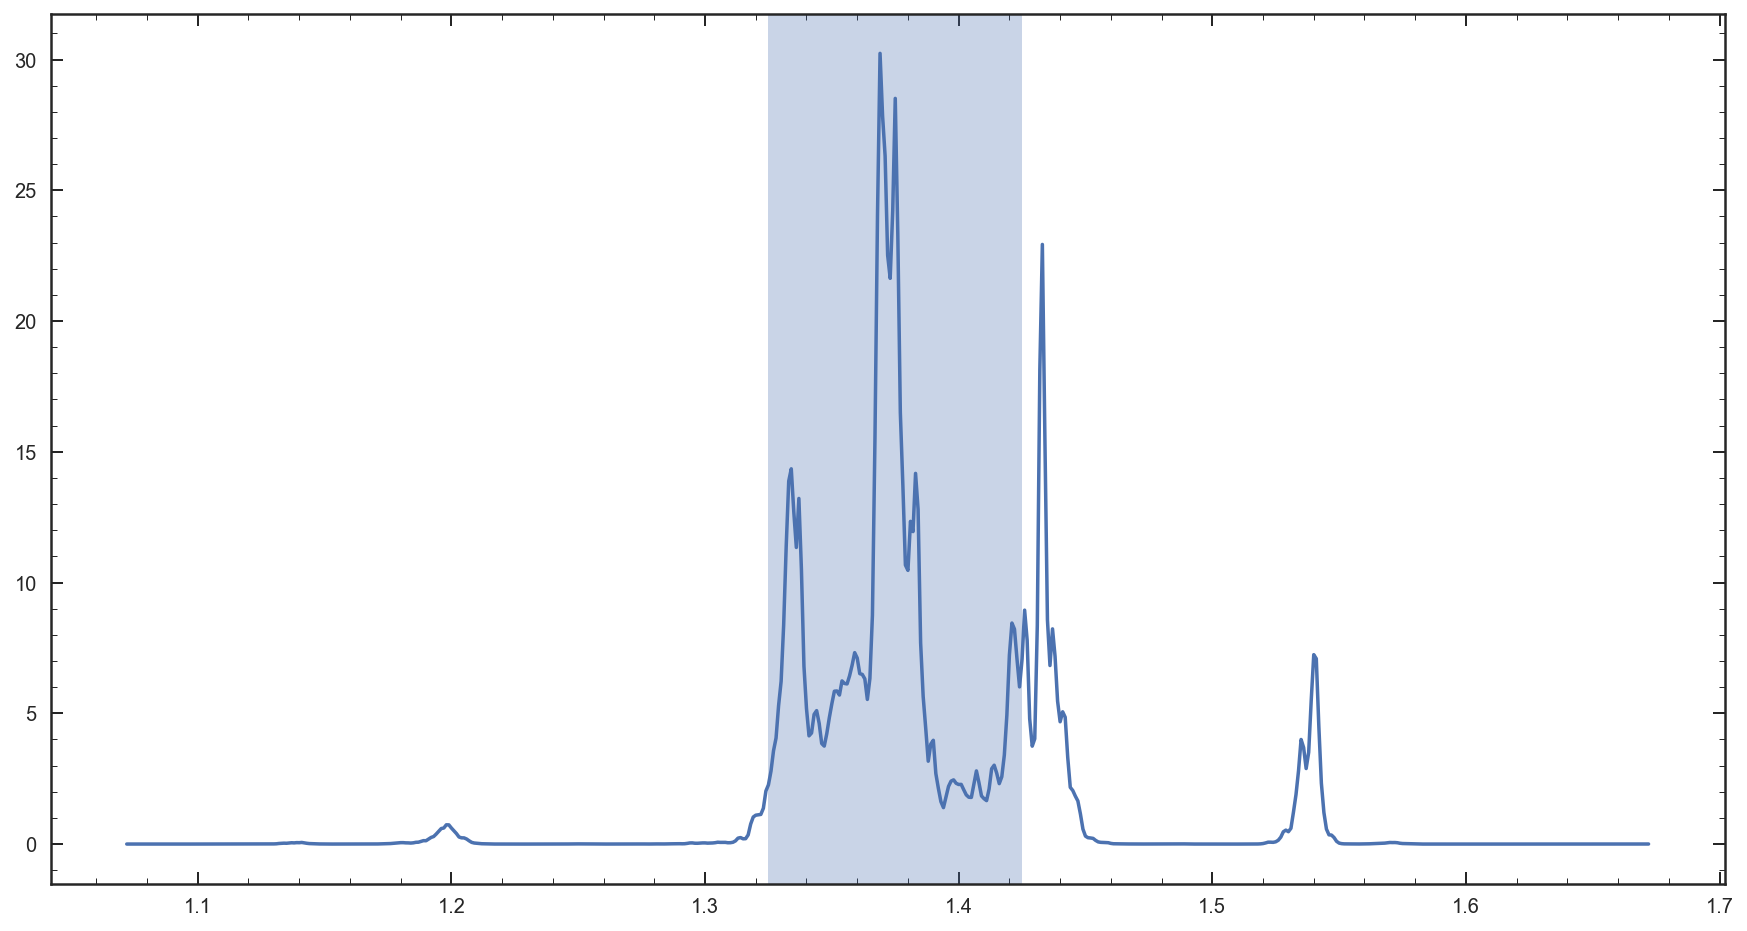

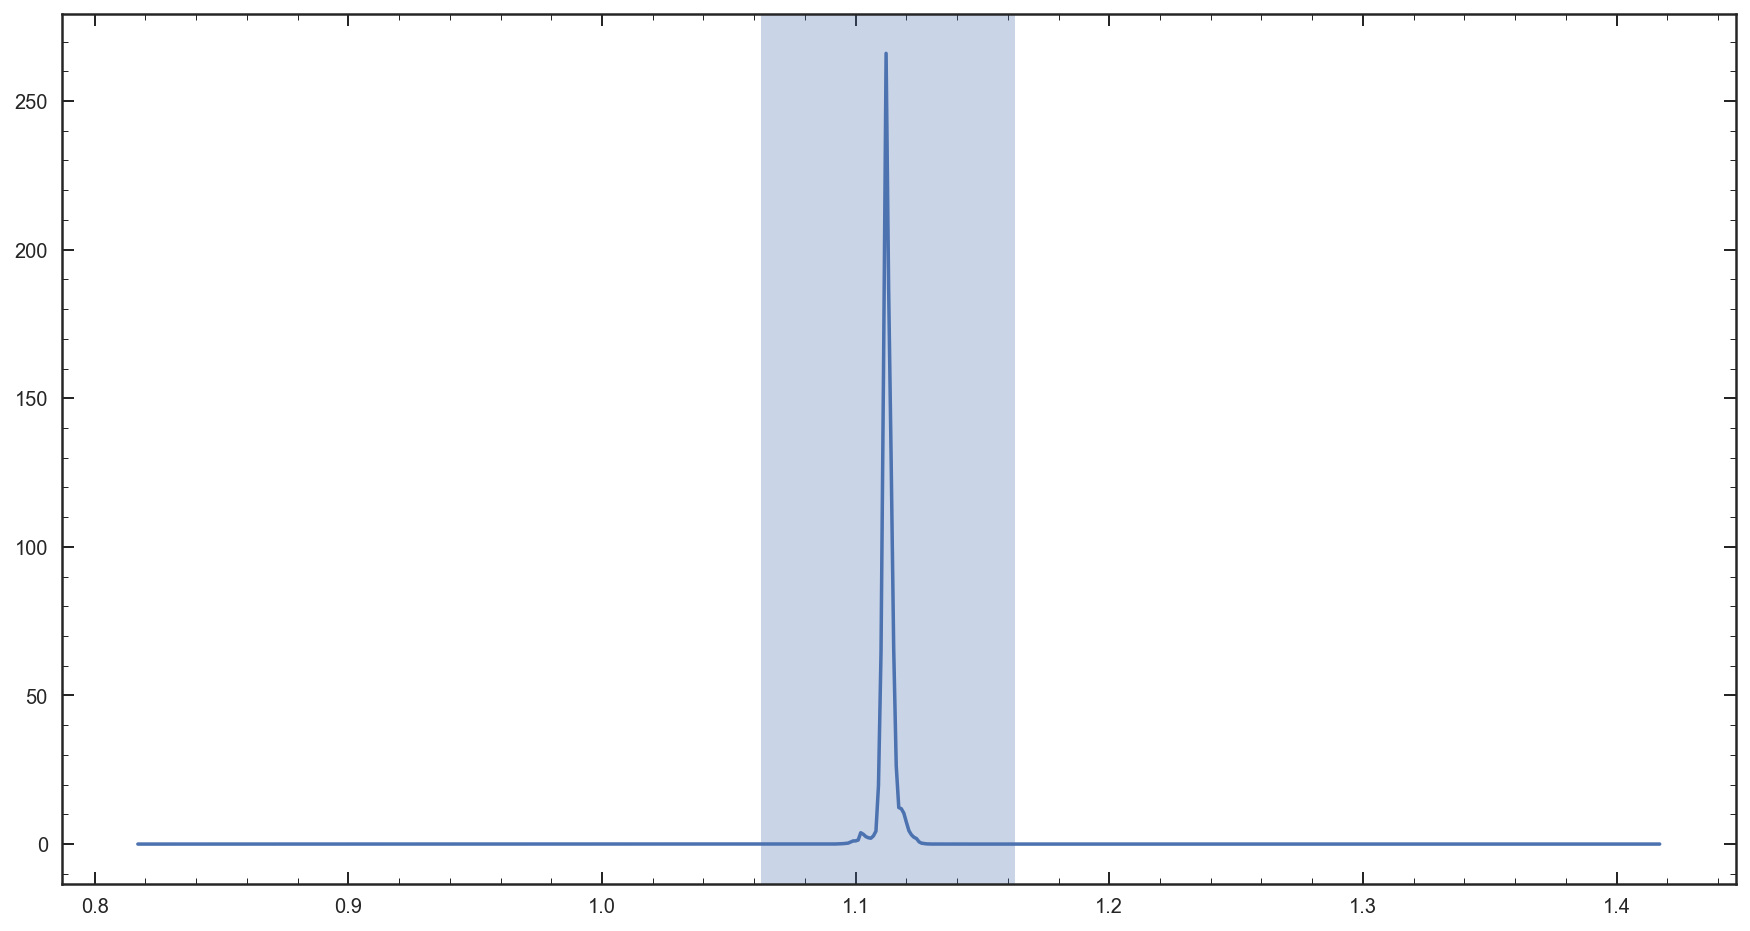

In [334]:
for i in galDB.index:
    z,Pz = np.load('../rshift_dat/{0}_hires_Pofz.npy'.format(galDB.gids[i]))
    med,mler,mher = Median_w_Error_cont(Pz,z)
    plt.figure(figsize=[15,8])
    plt.plot(z,Pz)
    plt.axvspan(med - 0.05,med + 0.05,alpha=0.3)